In [385]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
import scipy.stats as stats
from scipy.stats import linregress

In [386]:
# necessario creare una cartella dati fuori da questa
magistrale= pd.DataFrame(pd.read_excel("../dati/iscritti_magistrale_informatica.xls")) 
triennale= pd.DataFrame(pd.read_excel("../dati/iscritti_triennale_informatica.xls")) 
piani= pd.DataFrame(pd.read_excel("../dati/piani_informatica.xls"))

basi_di_dati= pd.DataFrame(pd.read_excel("../dati/20212223Anonim.xlsx",  sheet_name='Foglio1')) # 2022-2023

In [387]:
# verifico di avere un campione sufficiente all'analisi

Z = 1.96  # Livello di confidenza del 95%
sigma = 10  # Deviazione standard stimata
E = 2  # Margine di errore desiderato

# Calcolo della dimensione del campione
n = (Z * sigma / E) ** 2
n = math.ceil(n)  # Arrotonda per eccesso al numero intero più vicino

print(f"Dimensione del campione necessaria: {n}")

Dimensione del campione necessaria: 97


In [388]:
# percentuale donne in triennale: 14.4
print((triennale['GENERE'] == 'F').mean() * 100)

14.436363636363636


In [389]:
# join triennale
pt = pd.merge(piani, 
              triennale[['PROGRESSIVO', 'CODCLA', 'GENERE', 'ANAC_INGRESSO', 'ANAC_USCITA','DATA_LAUREA','SITUAZIONE_FINALE','VOTO_LAUREA','MEDIA_DIPLOMA','BASE_DIPLOMA','DIPLOMA_LODE','TIPO_ISTITUTO']], 
              how="right", 
              left_on=["PROGRESSIVO", "CODCLA"], 
              right_on=["PROGRESSIVO", "CODCLA"])

In [390]:
# pulizia dati

# elimino in piani_triennali i valori in cui ho NaN in CODICE_INS e DECODIFICA_INS
pt.dropna(subset=['CODICE_INS', 'DECODIFICA_INS'], how='all', inplace=True)

# miglioro leggibilità
pt['CODCLA'] = pt['CODCLA'].astype(int)
pt['CODICE_INS'] = pt['CODICE_INS'].astype(int)
pt['VOTO'] = pt['VOTO'].astype(int)

# elimino colonna rindondante (codcla separa triennale e magistrale)
pt['CODCLA'].unique()
pt.drop(columns=['CODCLA'], inplace=True)

# elimino insegnamenti con meno di 50 partecipanti (molti a scelta con solo 1 persona)
pt = pt[pt.groupby('DECODIFICA_INS')['PROGRESSIVO'].transform('size') >= 50] # -- osservare cambiamenti al variare di min

# rimozione idoneità
pt = pt[(pt['DECODIFICA_INS'] != 'CULTURA AZIENDALE') &
        (pt['DECODIFICA_INS'] != 'ELEMENTI DI CULTURA AZIENDALE, PROFESSIONALE, SOCIALE E GIURIDICA') &
        (pt['DECODIFICA_INS'] != 'GESTIONE AZIENDALE') &
        (pt['DECODIFICA_INS'] != 'LINGUA INGLESE 1') &
        (pt['DECODIFICA_INS'] != 'PERFEZIONAMENTO DELLA LINGUA INGLESE') &
        (pt['DECODIFICA_INS'] != 'PERFEZIONAMENTO DELLA LINGUA INGLESE  ')]

# elimino i voti maggiori di 31 (31: lode)
pt = pt[(pt['VOTO'] != 36) & # 36: dispensato, credo si rifersica a crediti acquistiti grazie ad un passaggio di carriera
        (pt['VOTO'] != 40) & # 40: tirocinio effettuato
        (pt['VOTO'] != 41) & # 41: tirocinio approvato
        (pt['VOTO'] != 46) & # 46: ofa non superati
        (pt['VOTO'] != 45) & # 45: superato (laurea, ofa, ...)
        (pt['VOTO'] != 96) & # 96: registrato per errore
# sarebbe interessante tenere i segeunti, ma non ho dati a sufficienza
        (pt['VOTO'] != 35) & # 35: ritirato
        (pt['VOTO'] != 44)]  # 44: respinto


In [391]:
pt['ANNO_ESAME'] = pd.to_datetime(pt['DATA_ESAME']).dt.year

In [392]:
# creo un db che unisce insegnamenti vecchi e nuovi

pt_vecchi = pt.copy()

pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'BASI DI DATI 2': 'BASI DI DATI'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'COMPLEMENTI DI ALGORITMI E STRUTTURE DATI (8 CFU)': 'ALGORITMI E STRUTTURE DATI'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'COMPUTAZIONE QUANTISTICA': 'FONDAMENTI DI COMPUTAZIONE QUANTISTICA'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'ELEMENTI DI MATEMATICA E LOGICA': 'ALGEBRA E LOGICA PER INFORMATICA'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({"FONDAMENTI DELL'INFORMATICA": 'TEORIA DEGLI AUTOMI E CALCOLABILITÀ'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'GEOMETRIA': 'ALGEBRA LINEARE E ANALISI NUMERICA'})    # ???
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'INGEGNERIA DEL SOFTWARE (6 CFU)': 'FONDAMENTI DI INGEGNERIA DEL SOFTWARE'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({"SISTEMI DI ELABORAZIONE DELL'INFORMAZIONE 1":"SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE"})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'SISTEMI DI ELABORAZIONE E DI TRASMISSIONE': "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE"})

# Non conosco
# SISTEMI ERP


In [393]:
def voto(voto):
    if voto >= 18 and voto <= 22:
        return '18-22'
    elif voto >= 23 and voto <= 27:
        return '23-27'
    elif voto >= 28 and voto <= 31:
        return '28-31'
    else:
        return 'Altro'

pt_vecchi['FASCIA_VOTO'] = pt_vecchi['VOTO'].apply(voto)

In [394]:
def categorizza(row):
    if pd.notnull(row['DATA_LAUREA']):
        return 'laurea'
    elif (row['SITUAZIONE_FINALE'] == 'BLOCCO CARRIERA PER MANCATO PAGAMENTO (CC/VIRTUALE)') or \
         (row['SITUAZIONE_FINALE'] == 'ISCRIZIONE NON ATTIVA PER CARRIERA APERTA') or \
         (row['SITUAZIONE_FINALE'] == 'RINUNCIATARIO') or \
         (row['SITUAZIONE_FINALE'] == 'CONGEDATO') or \
         (row['SITUAZIONE_FINALE'] == 'INTERRUZIONE DEGLI STUDI') or \
         (row['SITUAZIONE_FINALE'] == 'SOSPESO RISERVA MOB.INT.'):
        return 'non laurea'
    elif (row['SITUAZIONE_FINALE'] == 'ATTIVO') or \
         (row['SITUAZIONE_FINALE'] == 'MANCATO PAGAMENTO I/II RATA ') or \
         (row['SITUAZIONE_FINALE'] == 'ANNO DI CORSO SOTTO CONDIZIONE'):
        return 'in esecuzione'
    else:
        return 'non laurea'

pt_vecchi['CATEGORIA'] = pt_vecchi.apply(categorizza, axis=1)

In [395]:
def voto_laurea(voto_laurea):
    if voto_laurea >= 80 and voto_laurea <= 83:
        return '80-83'
    elif voto_laurea >= 84 and voto_laurea <=87:
        return '84-87'
    elif voto_laurea >= 88 and voto_laurea <= 91:
        return '88-91'
    elif voto_laurea >= 92 and voto_laurea <= 95:
        return '92-95'
    elif voto_laurea >= 96 and voto_laurea <= 99:
        return '96-99'
    elif voto_laurea >= 100 and voto_laurea <= 103:
        return '100-103'
    elif voto_laurea >= 104 and voto_laurea <= 107:
        return '104-107'
    elif voto_laurea >= 108 and voto_laurea <= 111:
        return '108-111'
    else:
        return 'Altro'

pt_vecchi['FASCIA_VOTO_LAUREA'] = pt_vecchi['VOTO_LAUREA'].apply(voto_laurea)

In [396]:
# proporzione voto diploma
# nuovo db, una riga per studente

def diploma(row):
    if (row['DIPLOMA_LODE'] > 0):
        return 111
    else:
        return round(row['MEDIA_DIPLOMA'] * 110 / row['BASE_DIPLOMA'], 2)

pt_val_finale = pt_vecchi.copy()
pt_val_finale = pt_val_finale[pt_val_finale['MEDIA_DIPLOMA'] > 0]
pt_val_finale = pt_val_finale[pt_val_finale['BASE_DIPLOMA'] > 0]

pt_val_finale['VOTO_DIPLOMA'] = pt_val_finale.apply(diploma, axis=1)

pt_val_finale = pt_val_finale.dropna(subset=['VOTO_DIPLOMA']) #elimino le righe con diploma null
pt_val_finale = pt_val_finale.groupby('PROGRESSIVO').first().reset_index()



In [397]:
pt_vecchi['ANNO_LAUREA'] = pd.to_datetime(pt_vecchi['DATA_LAUREA']).dt.year # 5844 valori nulli
#pt_vecchi['ANNO_LAUREA'].isnull().sum() 

In [398]:
def esami_anno(row):
    if row['DECODIFICA_INS'] in ["ALGEBRA E LOGICA PER INFORMATICA", "ALGORITMI E STRUTTURE DATI", "ARCHITETTURA DEI CALCOLATORI", "CALCULUS 1", "INTRODUZIONE ALLA PROGRAMMAZIONE"]:
        return 'PRIMO_ANNO'
    elif row['DECODIFICA_INS'] in ["ALGEBRA LINEARE E ANALISI NUMERICA", "ANALISI E PROGETTAZIONE DI ALGORITMI", "BASI DI DATI", "LINGUAGGI E PROGRAMMAZIONE ORIENTATA AGLI OGGETTI", "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE", "TEORIA DELL'INFORMAZIONE E INFERENZA"]:
        return 'SECONDO_ANNO'
    elif row['DECODIFICA_INS'] in ["COMPUTER SECURITY", "FONDAMENTI DI INGEGNERIA DEL SOFTWARE", "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI", "SVILUPPO DI APPLICAZIONI WEB"]:
        return 'TERZO_ANNO'
    elif row['DECODIFICA_INS'] in ["CALCULUS 2", "FONDAMENTI DI COMPUTAZIONE QUANTISTICA", "TEORIA DEGLI AUTOMI E CALCOLABILITÀ"]:
        return 'PROPEDEUTICO'
    elif row['DECODIFICA_INS'] == "TECNICHE AVANZATE DI PROGRAMMAZIONE":
        return 'TECNOLOGICO'
    elif row['DECODIFICA_INS'] in ["APP MULTIMEDIALI E INTERNET OF THINGS", "FONDAMENTI DELL'ELABORAZIONE DI SEGNALI E IMMAGINI", "INFORMATICA PER CREATIVITÀ, DIDATTICA E DIVULGAZIONE", "INTRODUZIONE ALLA DATA SCIENCE", "STRUMENTI PER LO SVILUPPO E GESTIONE DEL SOFTWARE", "WEB DESIGN"]:
        return 'SCELTA'
    else:
        return np.nan

pt['ESAMI_ANNO'] = pt.apply(esami_anno, axis=1)
pt = pt.dropna(subset=['ESAMI_ANNO'])

In [399]:
def voto_diploma(voto_diploma):
    if voto_diploma >= 66 and voto_diploma < 70:
        return '66-70'
    if voto_diploma >= 70 and voto_diploma < 75:
        return '71-75'
    if voto_diploma >= 75 and voto_diploma < 80:
        return '76-80'
    if voto_diploma >= 80 and voto_diploma < 85:
        return '81-85'
    if voto_diploma >= 85 and voto_diploma < 90:
        return '86-90'
    if voto_diploma >= 90 and voto_diploma < 95:
        return '91-95'
    if voto_diploma >= 95 and voto_diploma < 100:
        return '96-100'
    if voto_diploma >= 100 and voto_diploma < 105:
        return '101-105'
    if voto_diploma >= 105 and voto_diploma <= 111:
        return '106-111'
    else:
        return 'Altro'

pt_val_finale['FASCIA_VOTO_DIPLOMA'] = pt_val_finale['VOTO_DIPLOMA'].apply(voto_diploma)

In [400]:
dopo15_vecchi = pt_vecchi[pt_vecchi['ANNO_ESAME'] >= 2015]
dopo15 = pt[pt['ANNO_ESAME'] >= 2015]

In [401]:
# divido gli esami per modalità
# assumo che anche gli esami vecchi avessero le seguenti modalità

esami_orali = dopo15_vecchi[(dopo15_vecchi['DECODIFICA_INS'] == "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "ANALISI E PROGETTAZIONE DI ALGORITMI") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "SVILUPPO DI APPLICAZIONI WEB") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "FONDAMENTI DI COMPUTAZIONE QUANTISTICA")]

esami_scritti = dopo15_vecchi[(dopo15_vecchi['DECODIFICA_INS'] == "ALGEBRA E LOGICA PER INFORMATICA") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "ALGEBRA LINEARE E ANALISI NUMERICA") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "CALCULUS 2") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "COMPUTER SECURITY") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI") |
                 (dopo15_vecchi['DECODIFICA_INS'] == "FONDAMENTI DI INGEGNERIA DEL SOFTWARE")]

In [402]:
# ho creato successivamente una colonna per indicare in che anno del corso si presenta
primo_anno = dopo15[(dopo15['DECODIFICA_INS'] == "ALGEBRA E LOGICA PER INFORMATICA") |
                 (dopo15['DECODIFICA_INS'] == "ALGORITMI E STRUTTURE DATI") |
                 (dopo15['DECODIFICA_INS'] == "ARCHITETTURA DEI CALCOLATORI") |
                 (dopo15['DECODIFICA_INS'] == "CALCULUS 1") |
                 (dopo15['DECODIFICA_INS'] == "INTRODUZIONE ALLA PROGRAMMAZIONE")]


secondo_anno = dopo15[(dopo15['DECODIFICA_INS'] == "ALGEBRA LINEARE E ANALISI NUMERICA") |
                 (dopo15['DECODIFICA_INS'] == "ANALISI E PROGETTAZIONE DI ALGORITMI") |
                 (dopo15['DECODIFICA_INS'] == "BASI DI DATI") |
                 (dopo15['DECODIFICA_INS'] == "LINGUAGGI E PROGRAMMAZIONE ORIENTATA  AGLI OGGETTI") |
                 (dopo15['DECODIFICA_INS'] == "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE") |
                 (dopo15['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA")]

comune = dopo15[(dopo15['DECODIFICA_INS'] == "COMPUTER SECURITY") | # per tutti
                 (dopo15['DECODIFICA_INS'] == "FONDAMENTI DI INGEGNERIA DEL SOFTWARE") |
                 (dopo15['DECODIFICA_INS'] == "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI") |
                 (dopo15['DECODIFICA_INS'] == "SVILUPPO DI APPLICAZIONI WEB")]

propedeutico = dopo15[(dopo15['DECODIFICA_INS'] == "CALCULUS 2") |
                 (dopo15['DECODIFICA_INS'] == "FONDAMENTI DI COMPUTAZIONE QUANTISTICA") |
                 (dopo15['DECODIFICA_INS'] == "TEORIA DEGLI AUTOMI E CALCOLABILITÀ")]

tecnologico = dopo15[(dopo15['DECODIFICA_INS'] == "TECNICHE AVANZATE DI PROGRAMMAZIONE")]

scelta = dopo15[(dopo15['DECODIFICA_INS'] == "APP MULTIMEDIALI E INTERNET OF THINGS") |
                 (dopo15['DECODIFICA_INS'] == "FONDAMENTI DELL'ELABORAZIONE DI SEGNALI E IMMAGINI") |
                 (dopo15['DECODIFICA_INS'] == "INFORMATICA PER CREATIVITÀ, DIDATTICA E DIVULGAZIONE") |
                 (dopo15['DECODIFICA_INS'] == "INTRODUZIONE ALLA DATA SCIENCE") |
                 (dopo15['DECODIFICA_INS'] == "STRUMENTI PER LO SVILUPPO E GESTIONE DEL SOFTWARE") |
                 (dopo15['DECODIFICA_INS'] == "WEB DESIGN")]

terzo_anno = pd.concat([comune, propedeutico, tecnologico, scelta])
            

In [403]:
docenti_donne = dopo15[(dopo15['DECODIFICA_INS'] == "ALGORITMI E STRUTTURE DATI") |
                   (dopo15['DECODIFICA_INS'] == "INTRODUZIONE ALLA PROGRAMMAZIONE") |
                   (dopo15['DECODIFICA_INS'] == "BASI DI DATI") |
                   (dopo15['DECODIFICA_INS'] == "SVILUPPO DI APPLICAZIONI WEB") |
                   #(dopo15['DECODIFICA_INS'] == "TECNICHE AVANZATE DI PROGRAMMAZIONE") |
                   (dopo15['DECODIFICA_INS'] == "TEORIA DEGLI AUTOMI E CALCOLABILITÀ") |
                   (dopo15['DECODIFICA_INS'] == "FONDAMENTI DELL'ELABORAZIONE DI SEGNALI E IMMAGINI") |
                   (dopo15['DECODIFICA_INS'] == "INFORMATICA PER CREATIVITÀ, DIDATTICA E DIVULGAZIONE") |
                   (dopo15['DECODIFICA_INS'] == "INTRODUZIONE ALLA DATA SCIENCE")]

docenti_uomini = dopo15[(dopo15['DECODIFICA_INS'] == "ALGEBRA E LOGICA PER INFORMATICA") |
                    (dopo15['DECODIFICA_INS'] == "ARCHITETTURA DEI CALCOLATORI") |
                    (dopo15['DECODIFICA_INS'] == "CALCULUS 1") |
                    (dopo15['DECODIFICA_INS'] == "ALGEBRA LINEARE E ANALISI NUMERICA") |
                    (dopo15['DECODIFICA_INS'] == "LINGUAGGI E PROGRAMMAZIONE ORIENTATA  AGLI OGGETTI") |
                    (dopo15['DECODIFICA_INS'] == "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE") |
                    (dopo15['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA") |
                    (dopo15['DECODIFICA_INS'] == "COMPUTER SECURITY") |
                    (dopo15['DECODIFICA_INS'] == "FONDAMENTI DI INGEGNERIA DEL SOFTWARE") |
                    (dopo15['DECODIFICA_INS'] == "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI") |
                    (dopo15['DECODIFICA_INS'] == "CALCULUS 2") |
                    (dopo15['DECODIFICA_INS'] == "FONDAMENTI DI COMPUTAZIONE QUANTISTICA")]

### Analisi dei dati

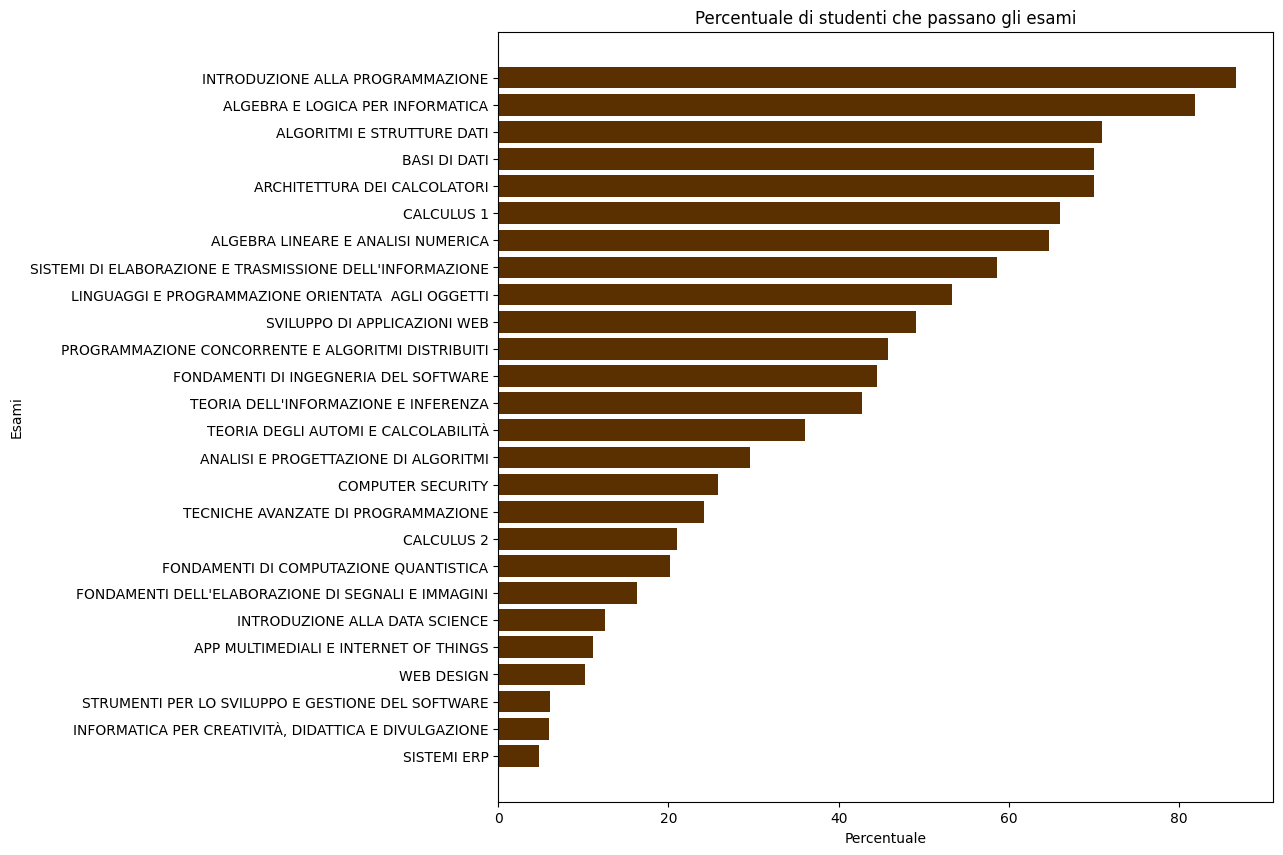

In [404]:
# percentuale studenti per esame, su quelli nel database
perc =(pt_vecchi.groupby('DECODIFICA_INS').size() / pt_vecchi['PROGRESSIVO'].nunique()) *100

perc_sorted = perc.sort_values()
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_sorted.index, perc_sorted, color='#5B3000')
plt.xlabel('Percentuale')
plt.ylabel('Esami')
plt.title('Percentuale di studenti che passano gli esami')
plt.show()

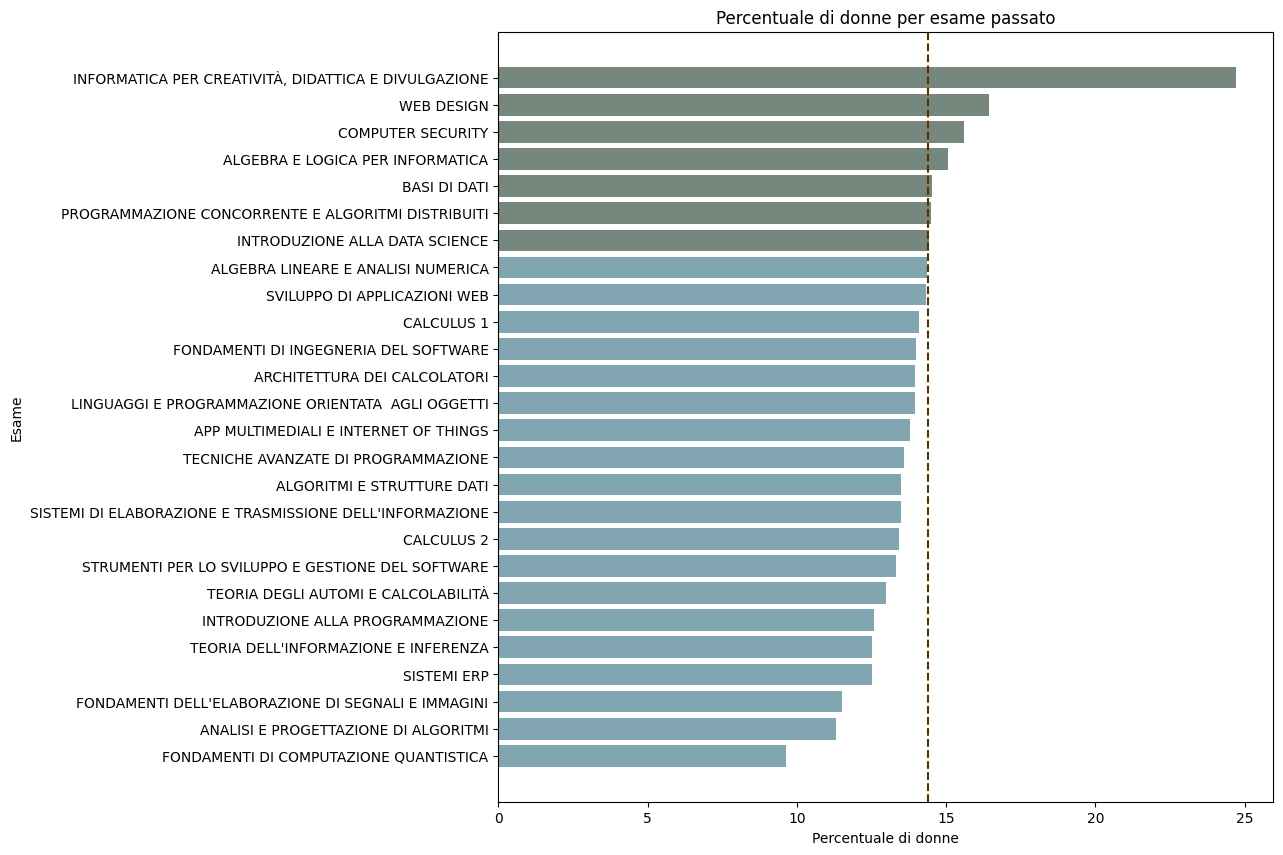

In [405]:
# visualizzazione percentuale di donne sul numero totale, di persone che hanno superato l'esame
perc_donne = ((pt_vecchi[pt_vecchi['GENERE'] == 'F'].groupby('DECODIFICA_INS').size() / pt_vecchi.groupby('DECODIFICA_INS').size()) * 100)#.astype(int)

perc_donne_sorted = perc_donne.sort_values()
colors = ['#82A6B1' if val < 14.4 else '#76877D' for val in perc_donne_sorted]
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_donne_sorted.index, perc_donne_sorted, color=colors)
plt.axvline(x=14.4, color='#5B3000', linestyle='--')
plt.xlabel('Percentuale di donne')
plt.ylabel('Esame')
plt.title('Percentuale di donne per esame passato')
plt.show()

In [406]:
# la percentuale esami passati
totale_voti = len(pt)  # non ci sono null #print(pt['CODICE_INS'].isnull().sum()) #print(pt['VOTO'].isnull().sum())
totale_voti_donne = len(pt[pt['GENERE'] == 'F']) 
(totale_voti_donne/totale_voti)*100

13.700848111025444

Prcentuale di voti leggermente più bassa del numero di donne, posso assumere che si fermino prima degli uomini nel percorso?

### Percentuale di voti per ogni esame, divisi per genere

In [407]:
media_voti = round(pt['VOTO'].mean(), 2)
print(f"Media valutazioni: {media_voti}")
media_voti_donne = round(pt[pt['GENERE'] == 'F']['VOTO'].mean(), 2)
print(f"Media valutazioni donne: {media_voti_donne}")
media_voti_uomini = round(pt[pt['GENERE'] == 'M']['VOTO'].mean(), 2)
print(f"Media valutazioni uomini: {media_voti_uomini}")

Media valutazioni: 25.18
Media valutazioni donne: 24.75
Media valutazioni uomini: 25.25


In [408]:
# colori grafici
#colore_donne = '#F1C40F'
#colore_uomini = '#EF5B5B'

colore_donne = '#1ED074'
colore_uomini = '#FFA22E'

In [409]:
# analizzo l'andamento generale dei voti per ogni esame (solo chi ha passato l'esame)
perc_voti = ((pt.groupby('VOTO').size()) / (totale_voti)) * 100

In [410]:
# analizzo l'andamento per le donne dei voti
perc_voti_donne = ((pt[pt['GENERE'] == 'F'].groupby('VOTO').size()) / (totale_voti_donne)) * 100

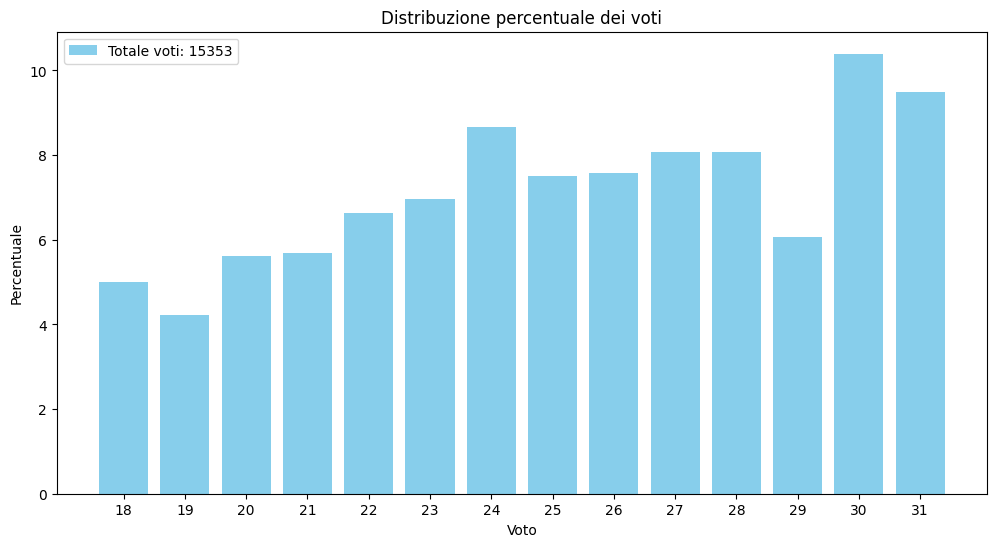

In [411]:
totale_voti = len(pt_vecchi) # uguale a pt_vecchi, entrambi senza null
voti = pt_vecchi['VOTO'].value_counts().sort_index()
percentuale_voti = (voti / totale_voti) * 100

plt.figure(figsize=(12, 6))
plt.bar(voti.index, percentuale_voti, color='skyblue', label=f'Totale voti: {totale_voti}')
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti')
plt.xticks(voti.index)

plt.legend()
plt.show()

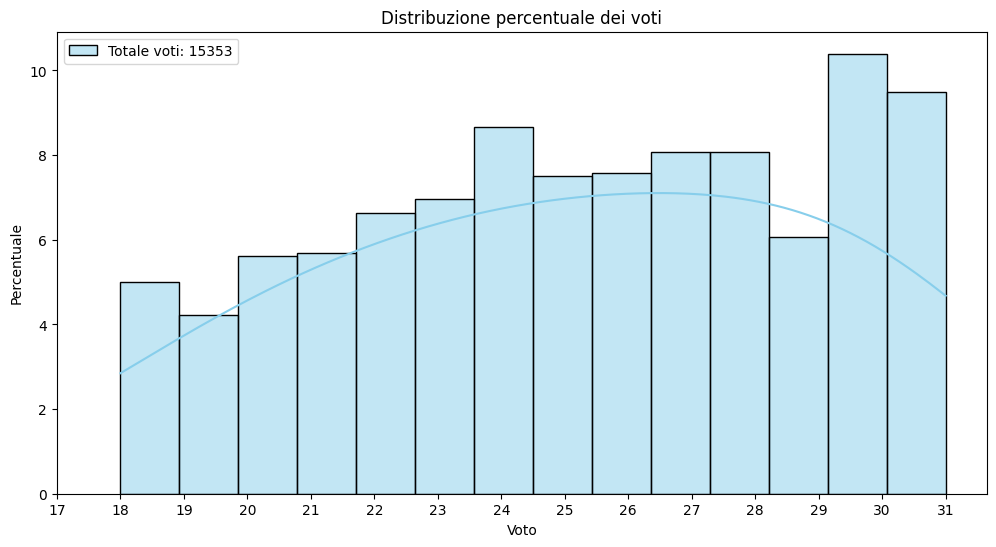

In [412]:
# ristampo lo stesso grafico!

totale_voti = len(pt_vecchi)
voti = pt_vecchi['VOTO'].value_counts().sort_index()
percentuale_voti = (voti / totale_voti) * 100

percentuale_voti_df = percentuale_voti.reset_index()
percentuale_voti_df.columns = ['Voto', 'Percentuale']

plt.figure(figsize=(12, 6))
sns.histplot(data=percentuale_voti_df, x='Voto', weights='Percentuale', kde=True, bins=len(voti), color='skyblue', label=f'Totale voti: {totale_voti}')

plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti')
plt.xticks(range(17, 32))

plt.legend()
plt.show()

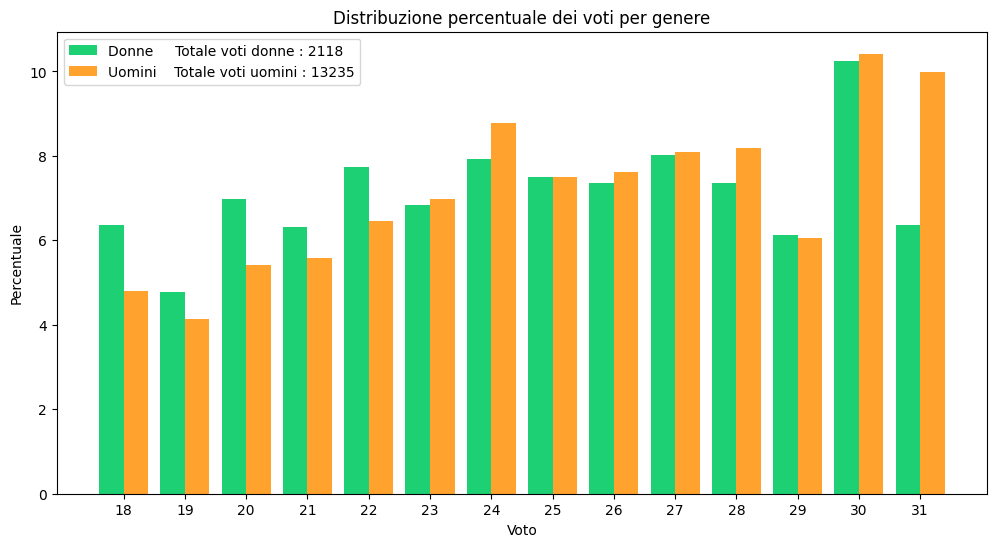

In [413]:
# visualizzazione della percentuale dei voti per genere

totale_voti_donne = len(pt_vecchi[pt_vecchi['GENERE'] == 'F'])
totale_voti_uomini = len(pt_vecchi[pt_vecchi['GENERE'] == 'M'])

voti_donne = pt_vecchi[pt_vecchi['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = pt_vecchi[pt_vecchi['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


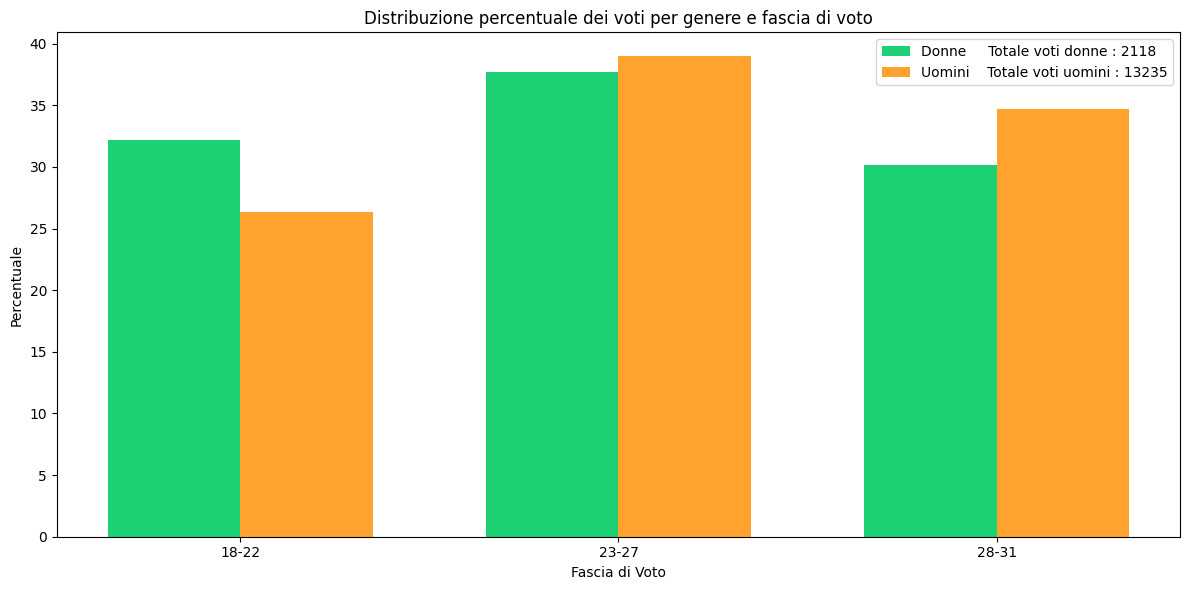

In [414]:
totale_voti = pt_vecchi.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


Osservo che le donne prediligono voti inferiori rispetto agli uomini, in particolare per le lodi

### Analisi per Laurea

In [415]:
# percentuale di lauree 
n_laurea = len(pt_vecchi[pt_vecchi['CATEGORIA'] == 'laurea'].groupby('PROGRESSIVO'))
n_studenti = pt_vecchi['PROGRESSIVO'].nunique()
#print(f'numero di laureati: {n_laurea}')
#print(f'numero di studenti: {n_studenti}')
perc_laurea = round((n_laurea / n_studenti) * 100)
print(f"Percentuale laureati: {perc_laurea}%")

print()

# percentuale di donne laureate su totale laureati
n_laurea_donne = len(pt_vecchi[(pt_vecchi['CATEGORIA'] == 'laurea') & (pt_vecchi['GENERE'] == 'F')].groupby('PROGRESSIVO'))
#print(f'numero di donne laureate: {n_laurea_donne}')
perc_laurea = round((n_laurea_donne / n_laurea) * 100)
print(f"Percentuale donne laureate sul totale dei laureati: {perc_laurea}%")

# percentuale di donne laureate sul totale di donne
donne = pt_vecchi[pt_vecchi['GENERE'] == 'F']
n_donne = donne['PROGRESSIVO'].nunique()
perc_laurea = round((n_laurea_donne / n_donne) * 100)
print(f"Percentuale donne laureate sul totale donne: {perc_laurea}%")

print()

# percentuale di uomini laureate su totale laureati
n_laurea_uomini = len(pt_vecchi[(pt_vecchi['CATEGORIA'] == 'laurea') & (pt_vecchi['GENERE'] == 'M')].groupby('PROGRESSIVO'))
#print(f'numero di uomini laureati: {n_laurea_uomini}')
perc_laurea = round((n_laurea_uomini / n_laurea) * 100)
print(f"Percentuale uomini laureati sul totale dei laureati: {perc_laurea}%")

# percentuale di uomini laureate sul totale di uomini
uomini = pt_vecchi[pt_vecchi['GENERE'] == 'M']
n_uomini = uomini['PROGRESSIVO'].nunique()
perc_laurea = round((n_laurea_uomini / n_uomini) * 100)
print(f"Percentuale uomini laureati sul totale uomini: {perc_laurea}%")

Percentuale laureati: 37%

Percentuale donne laureate sul totale dei laureati: 14%
Percentuale donne laureate sul totale donne: 36%

Percentuale uomini laureati sul totale dei laureati: 86%
Percentuale uomini laureati sul totale uomini: 37%


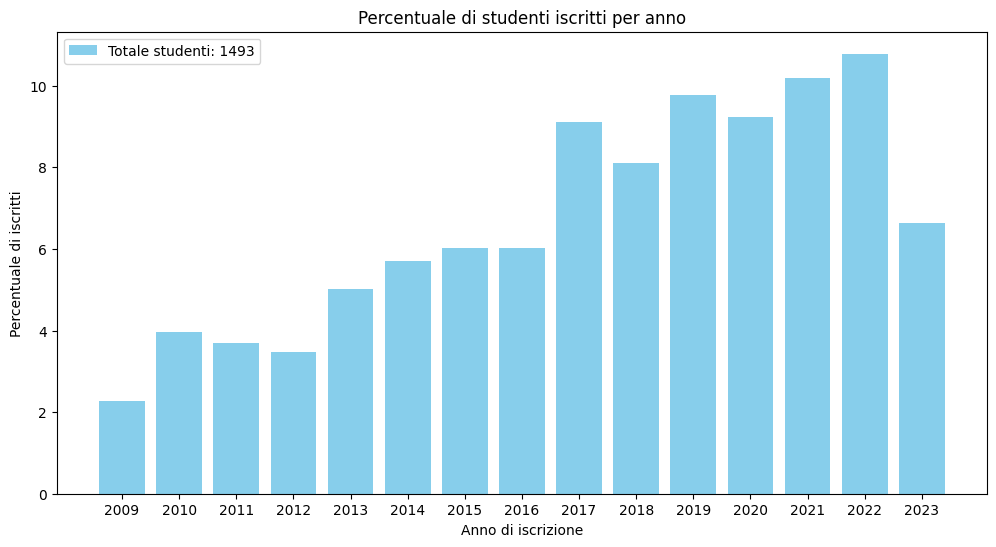

In [416]:
# Gli iscritti negli anni
totale_studenti = len(pt_vecchi.groupby('PROGRESSIVO')['ANAC_INGRESSO'].first())
laurea_per_anno = pt_vecchi.groupby('PROGRESSIVO')['ANAC_INGRESSO'].first().value_counts().sort_index()
percentuale_laureati_per_anno = (laurea_per_anno / totale_studenti) * 100

plt.figure(figsize=(12, 6))
plt.bar(percentuale_laureati_per_anno.index, percentuale_laureati_per_anno, color='skyblue', label=f'Totale studenti: {totale_studenti}')
plt.xlabel('Anno di iscrizione')
plt.ylabel('Percentuale di iscritti')
plt.title('Percentuale di studenti iscritti per anno')
plt.xticks(percentuale_laureati_per_anno.index)

plt.legend()
plt.show()

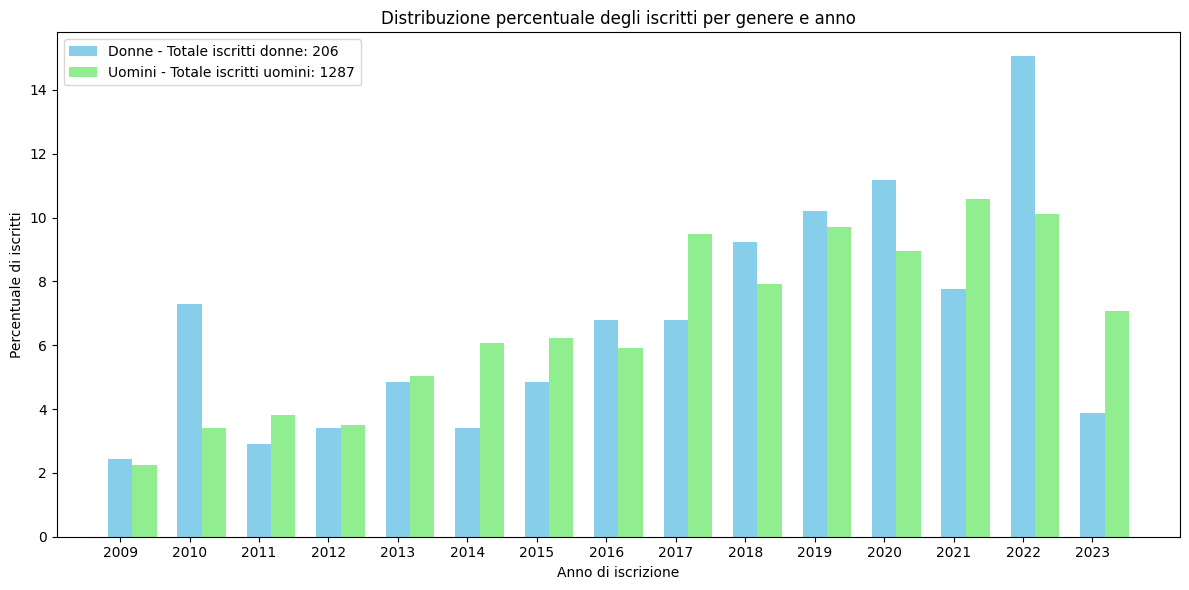

In [417]:
totale_studenti_donne = len(pt_vecchi[pt_vecchi['GENERE'] == 'F']['PROGRESSIVO'].unique())
totale_studenti_uomini = len(pt_vecchi[pt_vecchi['GENERE'] == 'M']['PROGRESSIVO'].unique())

iscritti_per_anno_donne = pt_vecchi[pt_vecchi['GENERE'] == 'F'].groupby('ANAC_INGRESSO')['PROGRESSIVO'].nunique().sort_index()
iscritti_per_anno_uomini = pt_vecchi[pt_vecchi['GENERE'] == 'M'].groupby('ANAC_INGRESSO')['PROGRESSIVO'].nunique().sort_index()

anni = sorted(set(iscritti_per_anno_donne.index).union(set(iscritti_per_anno_uomini.index)))
iscritti_per_anno_donne = iscritti_per_anno_donne.reindex(anni, fill_value=0)
iscritti_per_anno_uomini = iscritti_per_anno_uomini.reindex(anni, fill_value=0)

percentuale_iscritti_per_anno_donne = (iscritti_per_anno_donne / totale_studenti_donne) * 100
percentuale_iscritti_per_anno_uomini = (iscritti_per_anno_uomini / totale_studenti_uomini) * 100

bar_width = 0.35
r1 = np.arange(len(anni))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_iscritti_per_anno_donne, width=bar_width, label=f'Donne - Totale iscritti donne: {totale_studenti_donne}', color='skyblue')
plt.bar(r2, percentuale_iscritti_per_anno_uomini, width=bar_width, label=f'Uomini - Totale iscritti uomini: {totale_studenti_uomini}', color='lightgreen')
plt.xlabel('Anno di iscrizione')
plt.ylabel('Percentuale di iscritti')
plt.title('Distribuzione percentuale degli iscritti per genere e anno')
anni_str = [str(int(anno)) for anno in anni]
plt.xticks(r1, anni_str)
plt.legend()

plt.tight_layout()
plt.show()

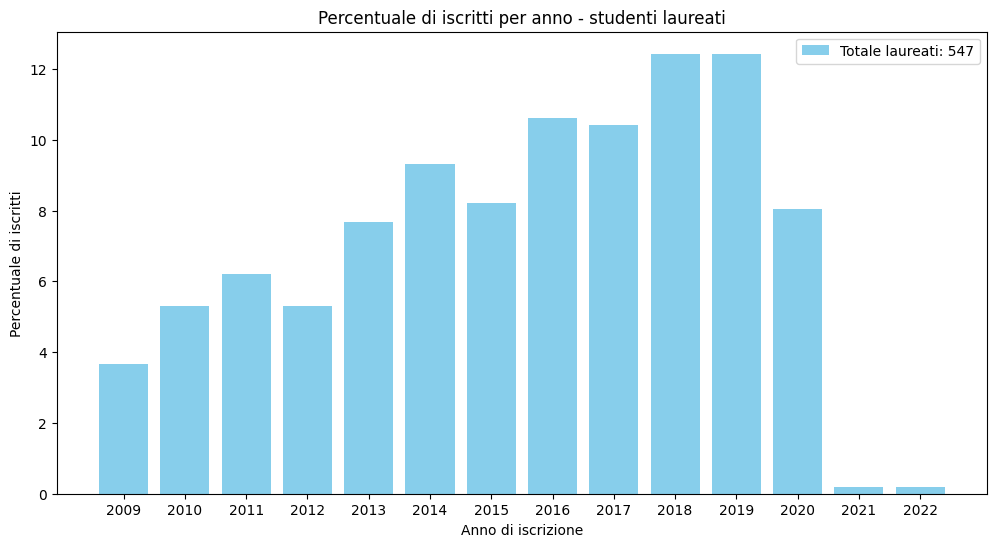

In [418]:
# In cha anno si sono iscritti i laureati
totale_laureati = len(pt_vecchi[pt_vecchi['ANNO_LAUREA'].notna()].groupby('PROGRESSIVO')['ANAC_INGRESSO'].first())
laureati_iscritti_per_anno = pt_vecchi[pt_vecchi['ANNO_LAUREA'].notna()].groupby('PROGRESSIVO')['ANAC_INGRESSO'].first().value_counts().sort_index()
percentuale_laureati_iscritti_per_anno = (laureati_iscritti_per_anno / totale_laureati) * 100

plt.figure(figsize=(12, 6))
plt.bar(percentuale_laureati_iscritti_per_anno.index, percentuale_laureati_iscritti_per_anno, color='skyblue', label=f'Totale laureati: {totale_laureati}')
plt.xlabel('Anno di iscrizione')
plt.ylabel('Percentuale di iscritti')
plt.title('Percentuale di iscritti per anno - studenti laureati')
plt.xticks(percentuale_laureati_iscritti_per_anno.index)

plt.legend()
plt.show()

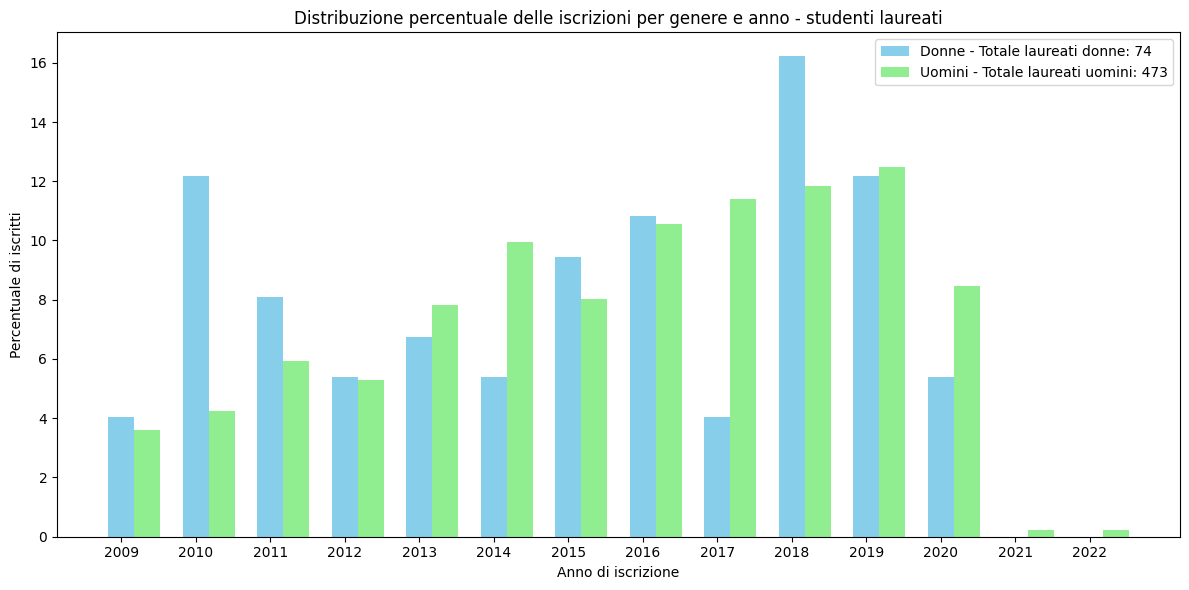

In [419]:
# In cha anno si sono iscritti i laureati, per genere

totale_laureati_donne = len(pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')]['PROGRESSIVO'].unique())
totale_laureati_uomini = len(pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')]['PROGRESSIVO'].unique())

laureati_per_anno_donne = pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')].groupby('ANAC_INGRESSO')['PROGRESSIVO'].nunique().sort_index()
laureati_per_anno_uomini = pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')].groupby('ANAC_INGRESSO')['PROGRESSIVO'].nunique().sort_index()

anni = sorted(set(laureati_per_anno_donne.index).union(set(laureati_per_anno_uomini.index)))
laureati_per_anno_donne = laureati_per_anno_donne.reindex(anni, fill_value=0)
laureati_per_anno_uomini = laureati_per_anno_uomini.reindex(anni, fill_value=0)

percentuale_laureati_iscritti_per_anno_donne = (laureati_per_anno_donne / totale_laureati_donne) * 100
percentuale_laureati_iscritti_per_anno_uomini = (laureati_per_anno_uomini / totale_laureati_uomini) * 100

bar_width = 0.35
r1 = np.arange(len(anni))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_laureati_iscritti_per_anno_donne, width=bar_width, label=f'Donne - Totale laureati donne: {totale_laureati_donne}', color='skyblue')
plt.bar(r2, percentuale_laureati_iscritti_per_anno_uomini, width=bar_width, label=f'Uomini - Totale laureati uomini: {totale_laureati_uomini}', color='lightgreen')
plt.xlabel('Anno di iscrizione')
plt.ylabel('Percentuale di iscritti')
plt.title('Distribuzione percentuale delle iscrizioni per genere e anno - studenti laureati')
anni_str = [str(int(anno)) for anno in anni]
plt.xticks(r1, anni_str)
plt.legend()

plt.tight_layout()
plt.show()

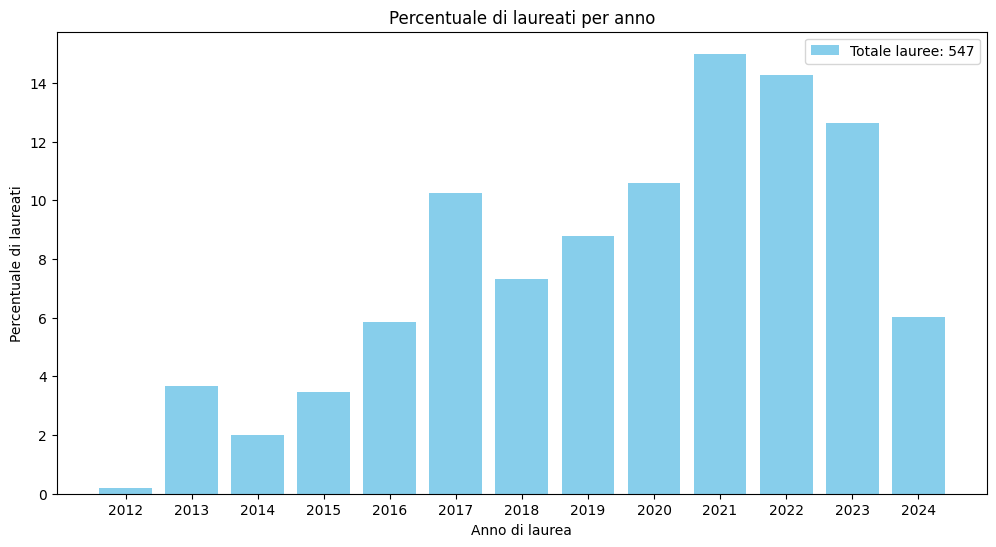

In [420]:
# ANNO_LAUREA perchè ANAC_USCITA non determina essersi laureati
totale_lauree = len(pt_vecchi[pt_vecchi['ANNO_LAUREA'].notna()].groupby('PROGRESSIVO')['ANNO_LAUREA'].first())
laurea_per_anno = pt_vecchi[pt_vecchi['ANNO_LAUREA'].notna()].groupby('PROGRESSIVO')['ANNO_LAUREA'].first().value_counts().sort_index()
percentuale_laureati_per_anno = (laurea_per_anno / totale_lauree) * 100

plt.figure(figsize=(12, 6))
plt.bar(percentuale_laureati_per_anno.index, percentuale_laureati_per_anno, color='skyblue', label=f'Totale lauree: {totale_lauree}')
plt.xlabel('Anno di laurea')
plt.ylabel('Percentuale di laureati')
plt.title('Percentuale di laureati per anno')
plt.xticks(percentuale_laureati_per_anno.index)

plt.legend()
plt.show()

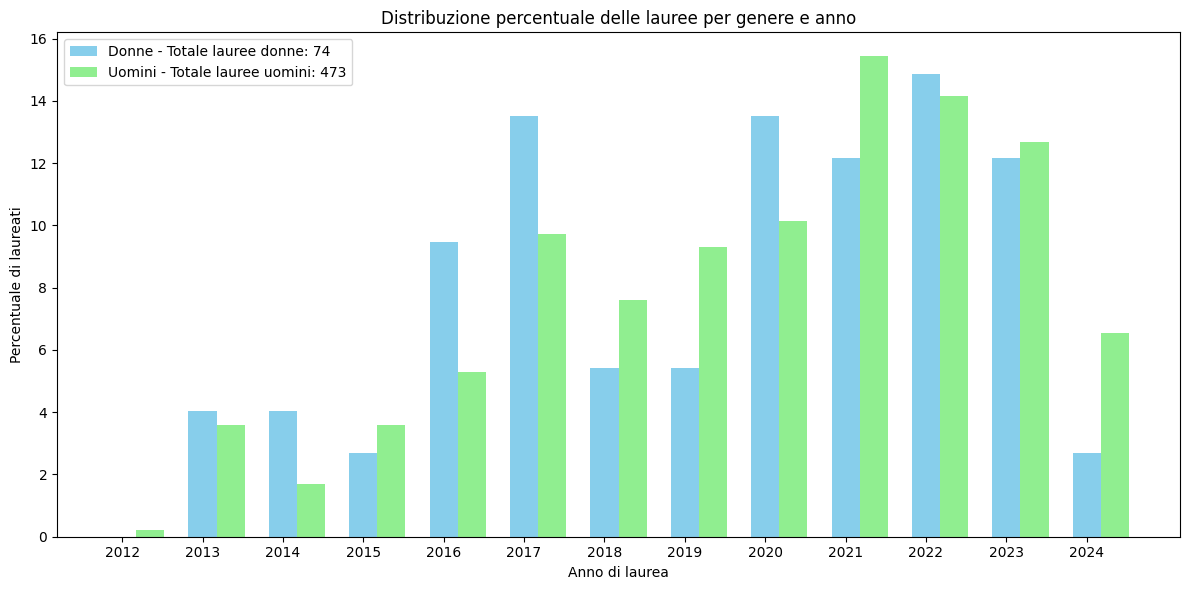

In [421]:
totale_lauree_donne = len(pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')]['PROGRESSIVO'].unique())
totale_lauree_uomini = len(pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')]['PROGRESSIVO'].unique())

laurea_per_anno_donne = pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')].groupby('ANNO_LAUREA')['PROGRESSIVO'].nunique().sort_index()
laurea_per_anno_uomini = pt_vecchi[(pt_vecchi['ANNO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')].groupby('ANNO_LAUREA')['PROGRESSIVO'].nunique().sort_index()

anni = sorted(set(laurea_per_anno_donne.index).union(set(laurea_per_anno_uomini.index)))
laurea_per_anno_donne = laurea_per_anno_donne.reindex(anni, fill_value=0)
laurea_per_anno_uomini = laurea_per_anno_uomini.reindex(anni, fill_value=0)

percentuale_lauree_per_anno_donne = (laurea_per_anno_donne / totale_lauree_donne) * 100
percentuale_lauree_per_anno_uomini = (laurea_per_anno_uomini / totale_lauree_uomini) * 100

bar_width = 0.35
r1 = np.arange(len(anni))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_lauree_per_anno_donne, width=bar_width, label=f'Donne - Totale lauree donne: {totale_lauree_donne}', color='skyblue')
plt.bar(r2, percentuale_lauree_per_anno_uomini, width=bar_width, label=f'Uomini - Totale lauree uomini: {totale_lauree_uomini}', color='lightgreen')
plt.xlabel('Anno di laurea')
plt.ylabel('Percentuale di laureati')
plt.title('Distribuzione percentuale delle lauree per genere e anno')
anni_str = [str(int(anno)) for anno in anni]
plt.xticks(r1, anni_str)
plt.legend()

plt.tight_layout()
plt.show()

### durata del percorso di laurea in media
scegliere tra ANAC_USCITA o DATA_LAUREA

----------------------------------------------------------------------------------------------------------------------------------------

In [422]:
pt_anni_lauree = pt_vecchi.dropna(subset=['ANAC_INGRESSO', 'ANAC_USCITA' , 'ANNO_LAUREA']).copy()
pt_anni_lauree['NUM_ANNI'] = pt_anni_lauree['ANAC_USCITA'] - pt_anni_lauree['ANAC_INGRESSO']

pt_anni_lauree['LAUREA-USC'] = (pt_anni_lauree['ANNO_LAUREA'] - pt_anni_lauree['ANAC_USCITA'])
pt_anni_lauree['ING-USC'] = (pt_anni_lauree['ANAC_USCITA'] - pt_anni_lauree['ANAC_INGRESSO'])


media = (pt_anni_lauree.groupby('PROGRESSIVO')['NUM_ANNI'].mean()).mean()
print(f'Il valore medio di numero di anni di laurea è: {media}')

Il valore medio di numero di anni di laurea è: 2.8153564899451555


2.8 anni sono 2 anni e 9 mesi

In [423]:
pt_anni_lauree[[ 'ANAC_USCITA', 'ANAC_INGRESSO', 'DATA_LAUREA', 'LAUREA-USC', 'ING-USC']].drop_duplicates()

,ANAC_USCITA,ANAC_INGRESSO,DATA_LAUREA,LAUREA-USC,ING-USC
2,2018,2013,2019-07-24,1.0,5
47,2013,2010,2014-07-24,1.0,3
69,2011,2009,2013-03-22,2.0,2
134,2013,2009,2014-10-22,1.0,4
189,2012,2010,2013-07-24,1.0,2
...,...,...,...,...,...
18381,2017,2014,2018-12-04,1.0,3
18461,2020,2017,2021-07-29,1.0,3
18528,2019,2016,2020-09-18,1.0,3
18603,2017,2013,2019-03-28,2.0,4


In [424]:
pt_anni_lauree['LAUREA-USC'].unique()

array([1., 2., 4., 7., 5., 6.])

In [425]:
pt_anni_lauree['ING-USC'].unique()

array([ 5,  3,  2,  4,  6,  9,  7,  1, 12,  0, 11, 10])

In [426]:
df_unique = pt_anni_lauree[['LAUREA-USC', 'ING-USC']].drop_duplicates()
count_combinations = pt_anni_lauree.groupby(['LAUREA-USC', 'ING-USC']).size().reset_index(name='count')
df_result = pd.merge(df_unique, count_combinations, on=['LAUREA-USC', 'ING-USC'], how='left')

print(df_result)

    LAUREA-USC  ING-USC  count
0          1.0        5    343
1          1.0        3   1166
2          2.0        2   1770
3          1.0        4    678
4          1.0        2   3688
5          1.0        6    215
6          1.0        9     35
7          2.0        4    317
8          2.0        7     84
9          2.0        3    700
10         2.0        1     53
11         2.0        5    182
12         1.0        1     31
13         4.0        2      2
14         1.0       12     14
15         2.0        6    152
16         4.0        1      2
17         7.0        0      2
18         5.0        0      4
19         6.0        0      4
20         6.0        2      3
21         4.0        0      9
22         1.0        0     12
23         1.0       11     17
24         2.0        0     10
25         2.0       10     16


----------------------------------------------------------------------------------------------------------------------------------------

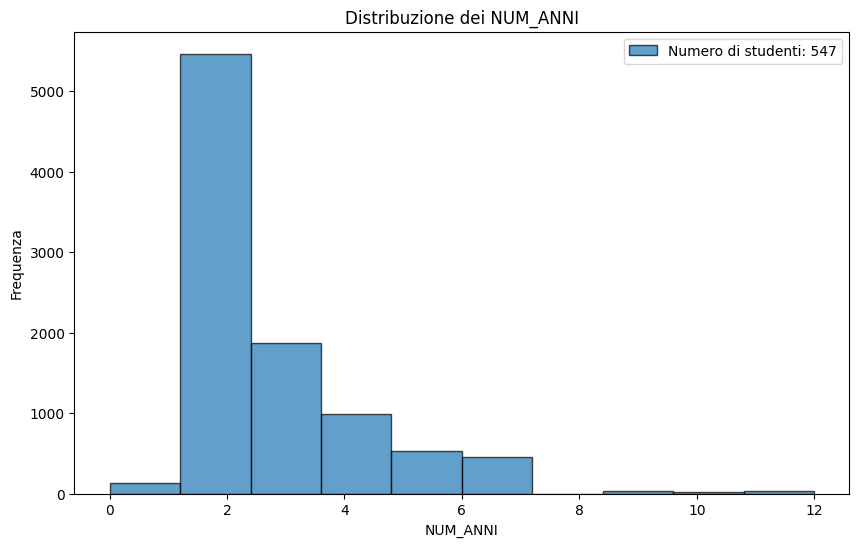

In [427]:
numero_studenti = len(pt_anni_lauree.groupby('PROGRESSIVO'))
plt.figure(figsize=(10, 6))
plt.hist(pt_anni_lauree['NUM_ANNI'], bins=10, edgecolor='black', alpha=0.7, label =f'Numero di studenti: {numero_studenti}')
plt.title('Distribuzione dei NUM_ANNI')
plt.xlabel('NUM_ANNI')
plt.ylabel('Frequenza')
plt.legend()
plt.show()

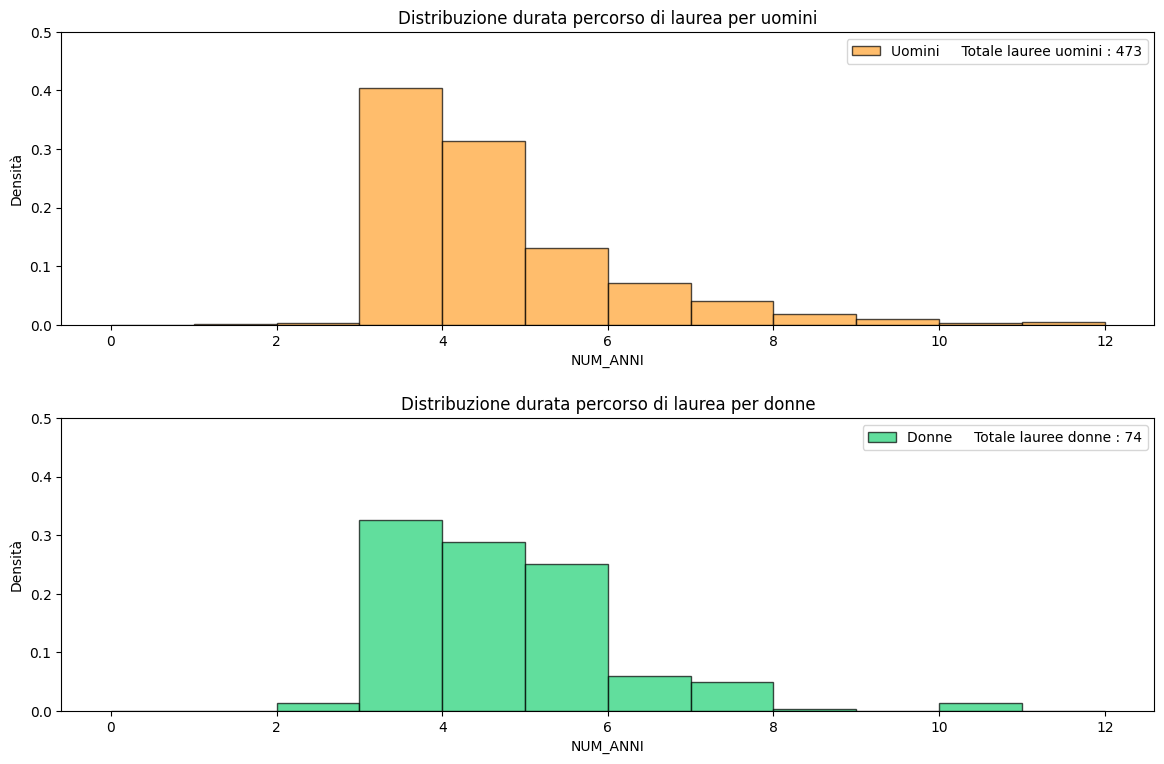

/tmp/ipykernel_4624/2428973645.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gruppo_genere.get_group('M')['NUM_ANNI'], gruppo_genere.get_group('F')['NUM_ANNI']], labels=['Uomo', 'Donna'])


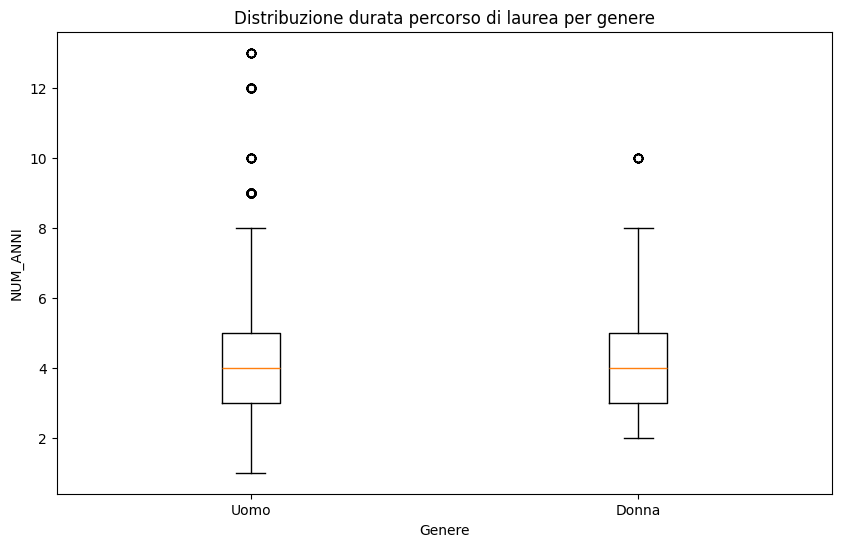

In [428]:
pt_anni_lauree = pt_vecchi.dropna(subset=['ANNO_LAUREA', 'ANAC_INGRESSO']).copy()
pt_anni_lauree['NUM_ANNI'] = pt_anni_lauree['ANNO_LAUREA'] - pt_anni_lauree['ANAC_INGRESSO']
gruppo_genere = pt_anni_lauree.groupby('GENERE')

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.hist(gruppo_genere.get_group('M')['NUM_ANNI'], bins=12, range=(0, 12), alpha=0.7, label=f'Uomini     Totale lauree uomini : {totale_lauree_uomini}', edgecolor='black', density=True, color=colore_uomini)
plt.title('Distribuzione durata percorso di laurea per uomini')
plt.xlabel('NUM_ANNI')
plt.ylabel('Densità')
plt.ylim(0, 0.5)
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(gruppo_genere.get_group('F')['NUM_ANNI'], bins=12, range=(0, 12), alpha=0.7, label=f'Donne     Totale lauree donne : {totale_lauree_donne}', edgecolor='black', density=True, color=colore_donne)
plt.title('Distribuzione durata percorso di laurea per donne')
plt.xlabel('NUM_ANNI')
plt.ylabel('Densità')
plt.ylim(0, 0.5)
plt.legend()

plt.tight_layout(pad=2.0)
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot([gruppo_genere.get_group('M')['NUM_ANNI'], gruppo_genere.get_group('F')['NUM_ANNI']], labels=['Uomo', 'Donna'])
plt.title('Distribuzione durata percorso di laurea per genere')
plt.xlabel('Genere')
plt.ylabel('NUM_ANNI')
plt.show()

### Valutazione laurea

In [429]:
# media del voto di laurea
media_voto_laurea = pt_vecchi[pt_vecchi['VOTO_LAUREA'].notna()].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].mean()
media_voto_laurea_donne = pt_vecchi[(pt_vecchi['GENERE'] == 'F') & (pt_vecchi['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].mean()
media_voto_laurea_uomini = pt_vecchi[(pt_vecchi['GENERE'] == 'M') & (pt_vecchi['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].mean()
print(f"Media del voto di laurea : {media_voto_laurea:.2f}")
print(f"Media del voto di laurea delle donne: {media_voto_laurea_donne:.2f}")
print(f"Media del voto di laurea degli uomini: {media_voto_laurea_uomini:.2f}")


Media del voto di laurea : 100.70
Media del voto di laurea delle donne: 99.62
Media del voto di laurea degli uomini: 100.87


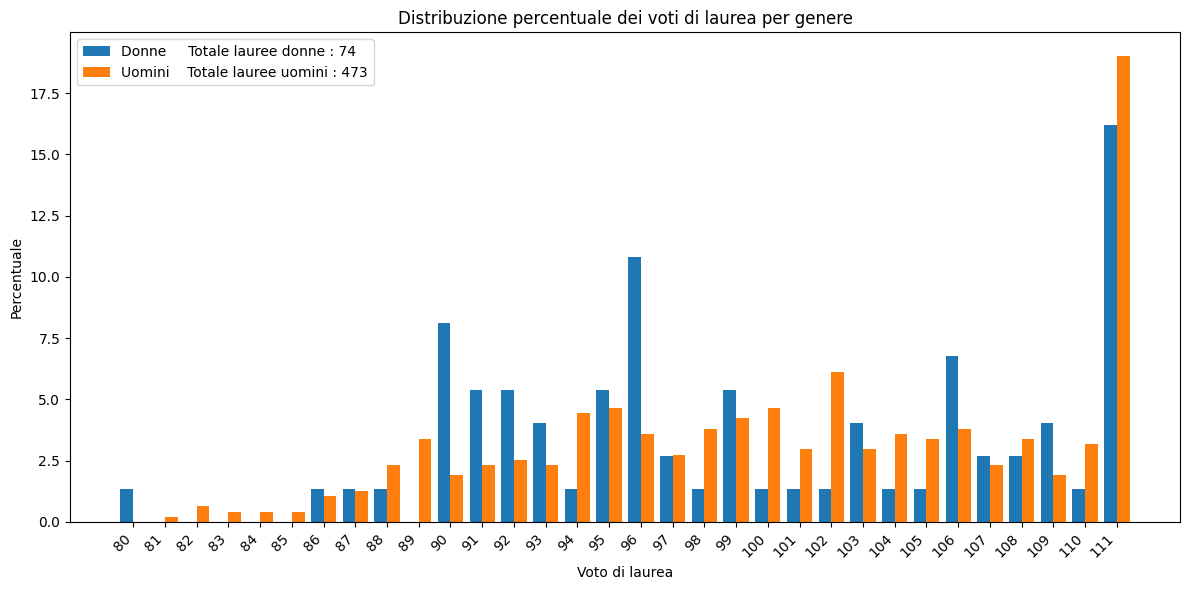

In [430]:
totale_lauree_donne = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')]['PROGRESSIVO'].unique())
totale_lauree_uomini = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')]['PROGRESSIVO'].unique())

voti_l_donne = pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].round().value_counts().sort_index()
voti_l_uomini = pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].round().value_counts().sort_index()

voti_l = sorted(set(voti_l_donne.index).union(set(voti_l_uomini.index)))
voti_l_donne = voti_l_donne.reindex(voti_l, fill_value=0)
voti_l_uomini = voti_l_uomini.reindex(voti_l, fill_value=0)

percentuale_voti_l_donne = (voti_l_donne / totale_lauree_donne) * 100
percentuale_voti_l_uomini = (voti_l_uomini / totale_lauree_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti_l))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_l_donne, width=bar_width, label=f'Donne     Totale lauree donne : {totale_lauree_donne}')
plt.bar(r2, percentuale_voti_l_uomini, width=bar_width, label=f'Uomini    Totale lauree uomini : {totale_lauree_uomini}')
plt.xlabel('Voto di laurea')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di laurea per genere')
plt.legend()

plt.xticks([r + bar_width/2 for r in range(len(voti_l))], [int(v) for v in voti_l])
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()

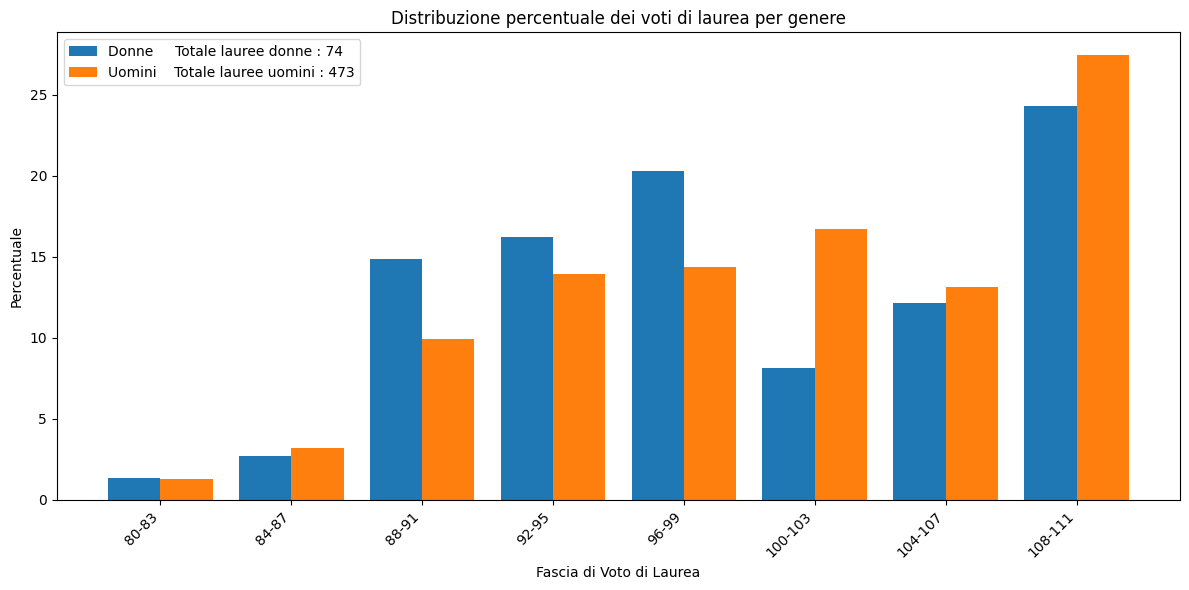

In [431]:
totale_lauree_donne = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'F')]['PROGRESSIVO'].unique())
totale_lauree_uomini = len(pt_vecchi[(pt_vecchi['VOTO_LAUREA'].notna()) & (pt_vecchi['GENERE'] == 'M')]['PROGRESSIVO'].unique())

voti_l_donne = pt_vecchi[(pt_vecchi['GENERE'] == 'F') & (pt_vecchi['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO')['FASCIA_VOTO_LAUREA'].first().value_counts().sort_index()
voti_l_uomini = pt_vecchi[(pt_vecchi['GENERE'] == 'M') & (pt_vecchi['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO')['FASCIA_VOTO_LAUREA'].first().value_counts().sort_index()

fasce_voto_ordinate = ['80-83', '84-87', '88-91', '92-95', '96-99', '100-103', '104-107', '108-111']
voti_l_donne = voti_l_donne.reindex(fasce_voto_ordinate, fill_value=0)
voti_l_uomini = voti_l_uomini.reindex(fasce_voto_ordinate, fill_value=0)

percentuale_voti_l_donne = (voti_l_donne / totale_lauree_donne) * 100
percentuale_voti_l_uomini = (voti_l_uomini / totale_lauree_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(fasce_voto_ordinate))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_l_donne, width=bar_width, label=f'Donne     Totale lauree donne : {totale_lauree_donne}')
plt.bar(r2, percentuale_voti_l_uomini, width=bar_width, label=f'Uomini    Totale lauree uomini : {totale_lauree_uomini}')
plt.xlabel('Fascia di Voto di Laurea')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di laurea per genere')
plt.legend()

plt.xticks([r + bar_width/2 for r in range(len(fasce_voto_ordinate))], fasce_voto_ordinate, rotation=45, ha='right')

plt.tight_layout()
plt.show()

Il campione delle donne è basso, per dare conclusioni <br>
Il trend è sempre lo stesso, sotto il 100 i voti sono a favore delle donne mentre sopra sono a favore degli uomini

### Analisi diploma superiore

In [432]:
# percentuale diploma superiore voti
media_voto_diploma = pt_val_finale['VOTO_DIPLOMA'].mean()
media_voto_diploma_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F']['VOTO_DIPLOMA'].mean()
media_voto_diploma_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M']['VOTO_DIPLOMA'].mean()
print(f"Media del voto di diploma : {media_voto_diploma:.2f}")
print(f"Media del voto di diploma delle donne: {media_voto_diploma_donne:.2f}")
print(f"Media del voto di diploma degli uomini: {media_voto_diploma_uomini:.2f}")


Media del voto di diploma : 87.34
Media del voto di diploma delle donne: 89.95
Media del voto di diploma degli uomini: 86.95


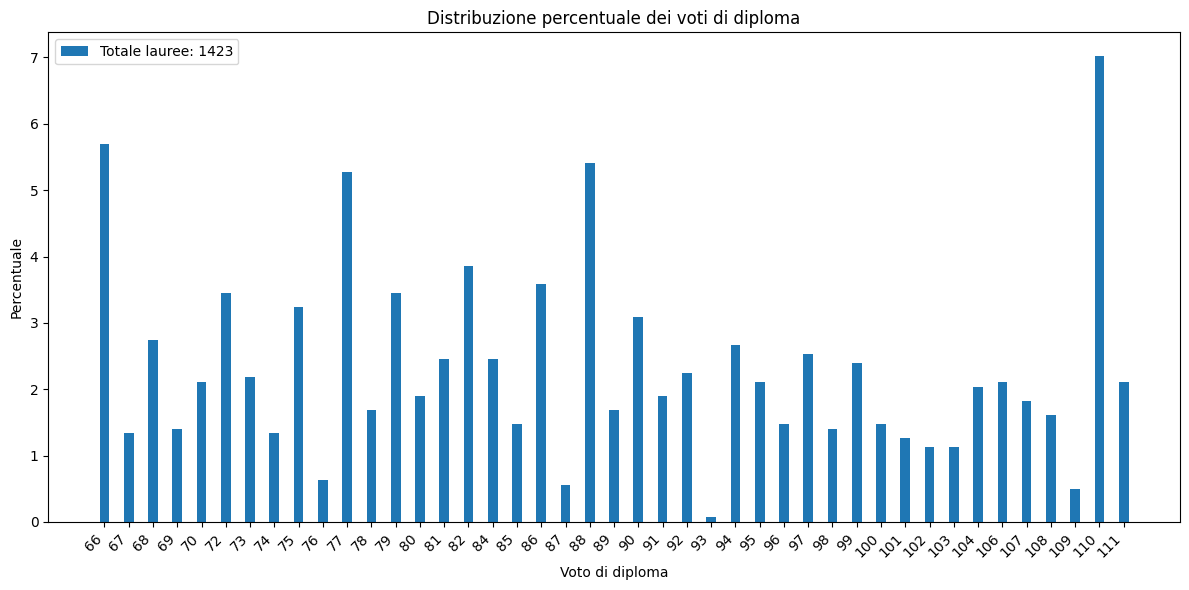

In [433]:
# distribuzione del voto di diploma

studenti = len(pt_val_finale)
voti_diploma = pt_val_finale['VOTO_DIPLOMA'].round().value_counts().sort_index()

voti_d = sorted(set(voti_diploma.index))
voti_diploma = voti_diploma.reindex(voti_d, fill_value=0)

percentuale_voti_diploma = (voti_diploma / studenti) * 100

bar_width = 0.4
r1 = np.arange(len(voti_d))

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_diploma, width=bar_width, label=f'Totale lauree: {studenti}')
plt.xlabel('Voto di diploma')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di diploma')

plt.xticks([r for r in range(len(voti_d))], [int(v) for v in voti_d])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.legend()
plt.show()


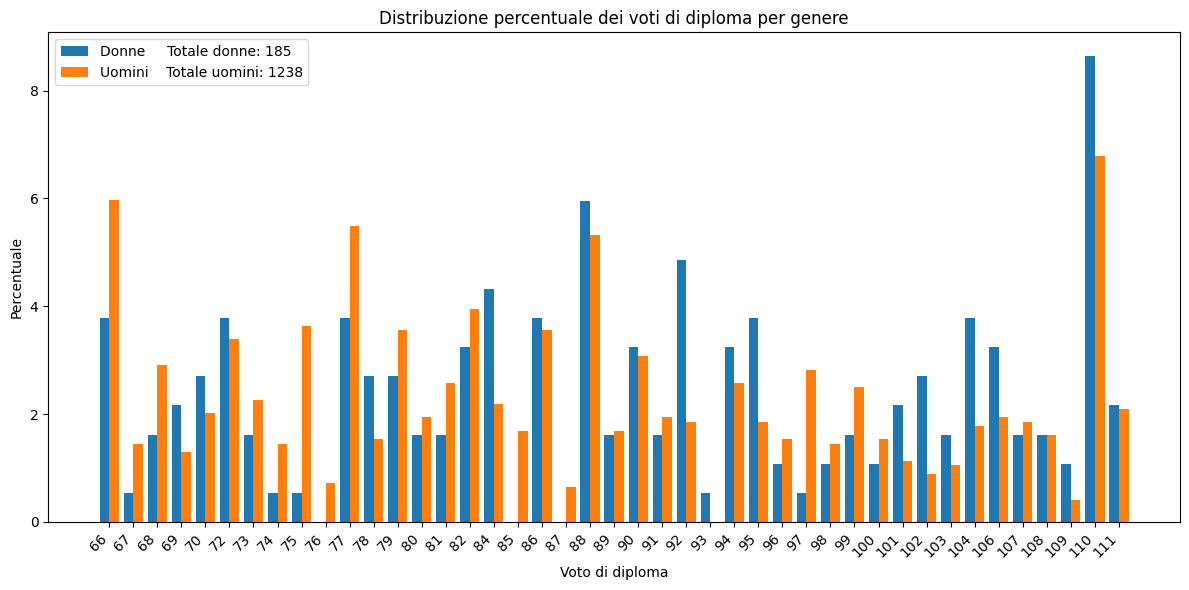

In [434]:
totale_donne = len(pt_val_finale[pt_val_finale['GENERE'] == 'F'])
totale_uomini = len(pt_val_finale[pt_val_finale['GENERE'] == 'M'])

voti_diploma_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F']['VOTO_DIPLOMA'].round().value_counts().sort_index()
voti_diploma_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M']['VOTO_DIPLOMA'].round().value_counts().sort_index()

voti_d = sorted(set(voti_diploma_donne.index).union(set(voti_diploma_uomini.index)))
voti_diploma_donne = voti_diploma_donne.reindex(voti_d, fill_value=0)
voti_diploma_uomini = voti_diploma_uomini.reindex(voti_d, fill_value=0)

percentuale_voti_diploma_donne = (voti_diploma_donne / totale_donne) * 100
percentuale_voti_diploma_uomini = (voti_diploma_uomini / totale_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti_d))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))

plt.bar(r1, percentuale_voti_diploma_donne, width=bar_width, label=f'Donne     Totale donne: {totale_donne}')
plt.bar(r2, percentuale_voti_diploma_uomini, width=bar_width, label=f'Uomini    Totale uomini: {totale_uomini}')

plt.xlabel('Voto di diploma')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di diploma per genere')
plt.xticks([r + bar_width/2 for r in range(len(voti_d))], [int(v) for v in voti_d])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.legend()
plt.show()


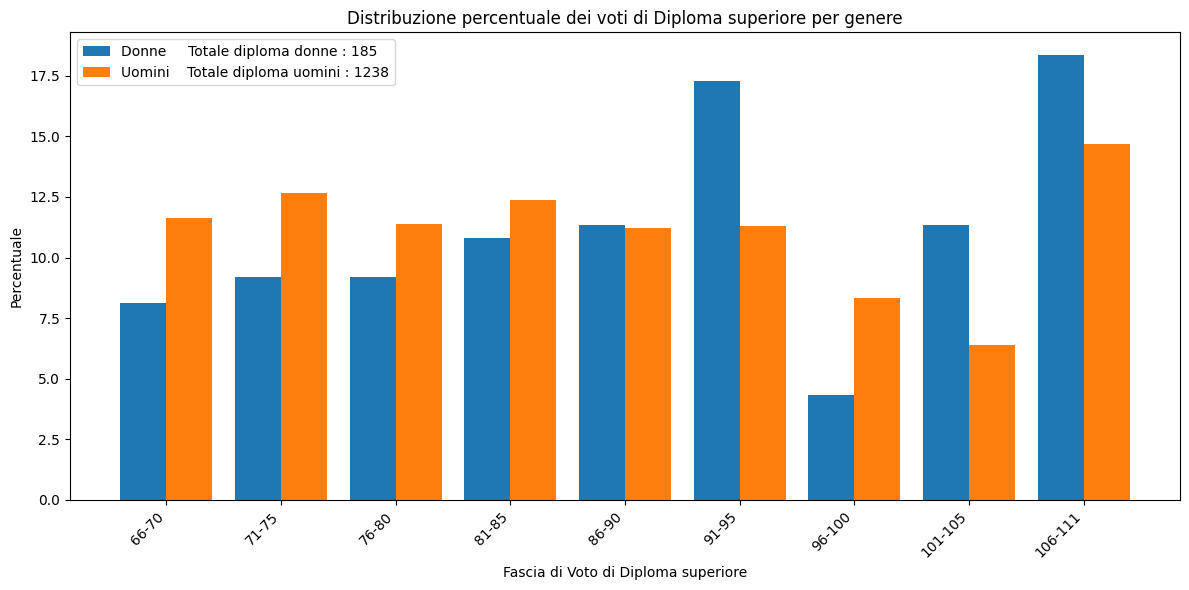

In [435]:
totale_diploma_donne = len(pt_val_finale[pt_val_finale['GENERE'] == 'F']['PROGRESSIVO'].unique())
totale_diploma_uomini = len(pt_val_finale[pt_val_finale['GENERE'] == 'M']['PROGRESSIVO'].unique())

voti_l_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F'].groupby('PROGRESSIVO')['FASCIA_VOTO_DIPLOMA'].first().value_counts().sort_index()
voti_l_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M'].groupby('PROGRESSIVO')['FASCIA_VOTO_DIPLOMA'].first().value_counts().sort_index()

fasce_voto_ordinate = ['66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100', '101-105', '106-111']
voti_l_donne = voti_l_donne.reindex(fasce_voto_ordinate, fill_value=0)
voti_l_uomini = voti_l_uomini.reindex(fasce_voto_ordinate, fill_value=0)

percentuale_voti_l_donne = (voti_l_donne / totale_diploma_donne) * 100
percentuale_voti_l_uomini = (voti_l_uomini / totale_diploma_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(fasce_voto_ordinate))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_l_donne, width=bar_width, label=f'Donne     Totale diploma donne : {totale_diploma_donne}')
plt.bar(r2, percentuale_voti_l_uomini, width=bar_width, label=f'Uomini    Totale diploma uomini : {totale_diploma_uomini}')
plt.xlabel('Fascia di Voto di Diploma superiore')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di Diploma superiore per genere')
plt.legend()

plt.xticks([r + bar_width/2 for r in range(len(fasce_voto_ordinate))], fasce_voto_ordinate, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Voto diploma superiore e Laurea

In [436]:
pt_val_finale = pt_val_finale.dropna(subset='VOTO_LAUREA')

In [437]:
# media del voto di laurea
media_voto_laurea = pt_val_finale[pt_val_finale['VOTO_LAUREA'].notna()].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].mean()
media_voto_laurea_donne = pt_val_finale[(pt_val_finale['GENERE'] == 'F') & (pt_val_finale['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].mean()
media_voto_laurea_uomini = pt_val_finale[(pt_val_finale['GENERE'] == 'M') & (pt_val_finale['VOTO_LAUREA'].notna())].groupby('PROGRESSIVO').first()['VOTO_LAUREA'].mean()
print(f"Media del voto di laurea : {media_voto_laurea:.2f}")
print(f"Media del voto di laurea delle donne: {media_voto_laurea_donne:.2f}")
print(f"Media del voto di laurea degli uomini: {media_voto_laurea_uomini:.2f}")


Media del voto di laurea : 100.82
Media del voto di laurea delle donne: 99.99
Media del voto di laurea degli uomini: 100.95


In [438]:
# percentuale diploma superiore voti
media_voto_diploma = pt_val_finale['VOTO_DIPLOMA'].mean()
media_voto_diploma_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F']['VOTO_DIPLOMA'].mean()
media_voto_diploma_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M']['VOTO_DIPLOMA'].mean()
print(f"Media del voto di diploma : {media_voto_diploma:.2f}")
print(f"Media del voto di diploma delle donne: {media_voto_diploma_donne:.2f}")
print(f"Media del voto di diploma degli uomini: {media_voto_diploma_uomini:.2f}")

Media del voto di diploma : 87.75
Media del voto di diploma delle donne: 91.91
Media del voto di diploma degli uomini: 87.14


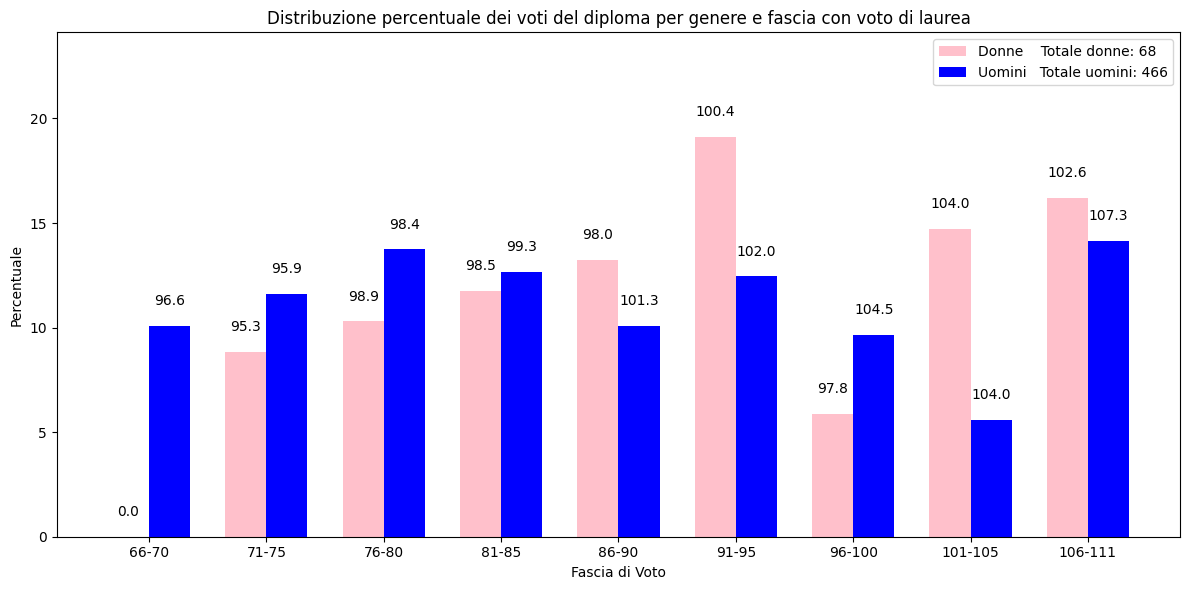

In [439]:
fasce_diploma = ['66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100', '101-105', '106-111']

totale_donne =  len(pt_val_finale[pt_val_finale['GENERE'] == 'F'])
totale_uomini =  len(pt_val_finale[pt_val_finale['GENERE'] == 'M'])

percentuali_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F']['FASCIA_VOTO_DIPLOMA'].value_counts(normalize=True) * 100
percentuali_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M']['FASCIA_VOTO_DIPLOMA'].value_counts(normalize=True) * 100
percentuali_donne = percentuali_donne.reindex(fasce_diploma, fill_value=0)
percentuali_uomini = percentuali_uomini.reindex(fasce_diploma, fill_value=0)

media_voti_laurea_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F'].groupby('FASCIA_VOTO_DIPLOMA')['VOTO_LAUREA'].mean()
media_voti_laurea_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M'].groupby('FASCIA_VOTO_DIPLOMA')['VOTO_LAUREA'].mean()
media_voti_laurea_donne = media_voti_laurea_donne.reindex(fasce_diploma, fill_value=0)
media_voti_laurea_uomini = media_voti_laurea_uomini.reindex(fasce_diploma, fill_value=0)

bar_width = 0.35
r1 = np.arange(len(fasce_diploma))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12,6))

plt.bar(r1, percentuali_donne, label=f'Donne    Totale donne: {totale_donne}', color='pink', width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini   Totale uomini: {totale_uomini}', color='blue', width=bar_width)

for i, fascia in enumerate(fasce_diploma):
    media_voto_donne = media_voti_laurea_donne[fascia]
    media_voto_uomini = media_voti_laurea_uomini[fascia]
    plt.text(r1[i], percentuali_donne[fascia] + 1, f'{media_voto_donne:.1f}', ha='center', fontsize=10)
    plt.text(r2[i], percentuali_uomini[fascia] + 1, f'{media_voto_uomini:.1f}', ha='center', fontsize=10)

plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti del diploma per genere e fascia con voto di laurea')
plt.xticks(r1 + bar_width/2, fasce_diploma)
plt.ylim(0, max(percentuali_donne.max(), percentuali_uomini.max()) + 5)
plt.legend()

plt.tight_layout()
plt.show()


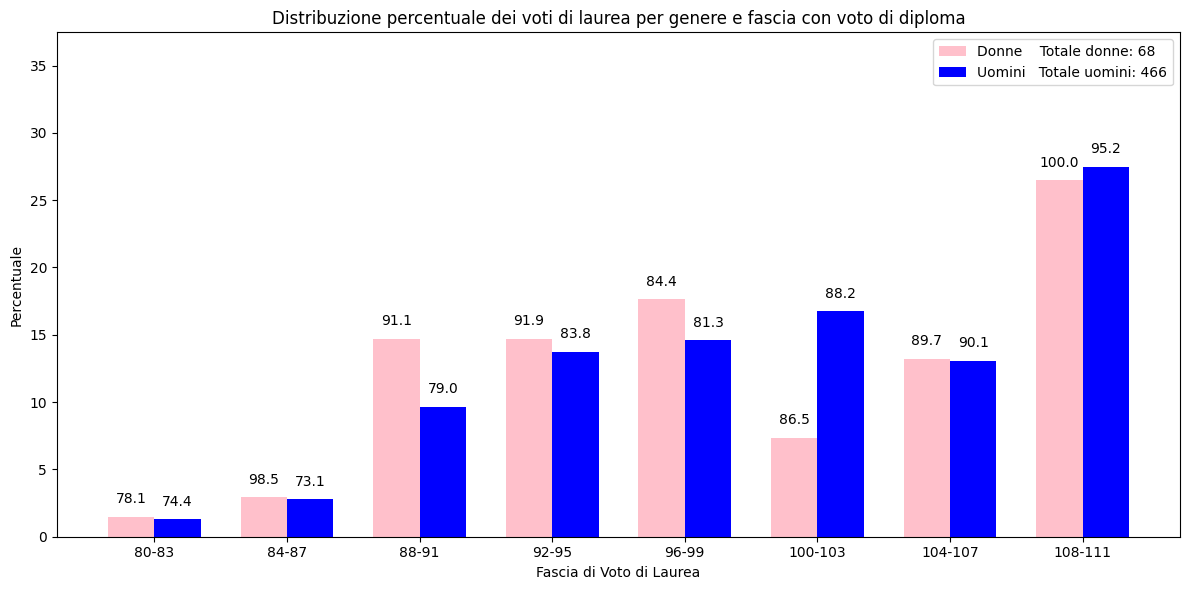

In [440]:
fasce_laurea = ['80-83', '84-87', '88-91', '92-95', '96-99', '100-103', '104-107', '108-111']

totale_donne = len(pt_val_finale[pt_val_finale['GENERE'] == 'F'])
totale_uomini = len(pt_val_finale[pt_val_finale['GENERE'] == 'M'])

percentuali_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F']['FASCIA_VOTO_LAUREA'].value_counts(normalize=True) * 100
percentuali_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M']['FASCIA_VOTO_LAUREA'].value_counts(normalize=True) * 100
percentuali_donne = percentuali_donne.reindex(fasce_laurea, fill_value=0)
percentuali_uomini = percentuali_uomini.reindex(fasce_laurea, fill_value=0)

media_voti_diploma_donne = pt_val_finale[pt_val_finale['GENERE'] == 'F'].groupby('FASCIA_VOTO_LAUREA')['VOTO_DIPLOMA'].mean()
media_voti_diploma_uomini = pt_val_finale[pt_val_finale['GENERE'] == 'M'].groupby('FASCIA_VOTO_LAUREA')['VOTO_DIPLOMA'].mean()
media_voti_diploma_donne = media_voti_diploma_donne.reindex(fasce_laurea, fill_value=0)
media_voti_diploma_uomini = media_voti_diploma_uomini.reindex(fasce_laurea, fill_value=0)

bar_width = 0.35
r1 = np.arange(len(fasce_laurea))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))

plt.bar(r1, percentuali_donne, label=f'Donne    Totale donne: {totale_donne}', color='pink', width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini   Totale uomini: {totale_uomini}', color='blue', width=bar_width)

for i, fascia in enumerate(fasce_laurea):
    media_voto_donne = media_voti_diploma_donne[fascia]
    media_voto_uomini = media_voti_diploma_uomini[fascia]
    plt.text(r1[i], percentuali_donne[fascia] + 1, f'{media_voto_donne:.1f}', ha='center', fontsize=10)
    plt.text(r2[i], percentuali_uomini[fascia] + 1, f'{media_voto_uomini:.1f}', ha='center', fontsize=10)

plt.xlabel('Fascia di Voto di Laurea')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti di laurea per genere e fascia con voto di diploma')
plt.xticks(r1 + bar_width/2, fasce_laurea)
plt.ylim(0, max(percentuali_donne.max(), percentuali_uomini.max()) + 10)
plt.legend()

plt.tight_layout()
plt.show()


In [441]:
grado_polinomio = 6

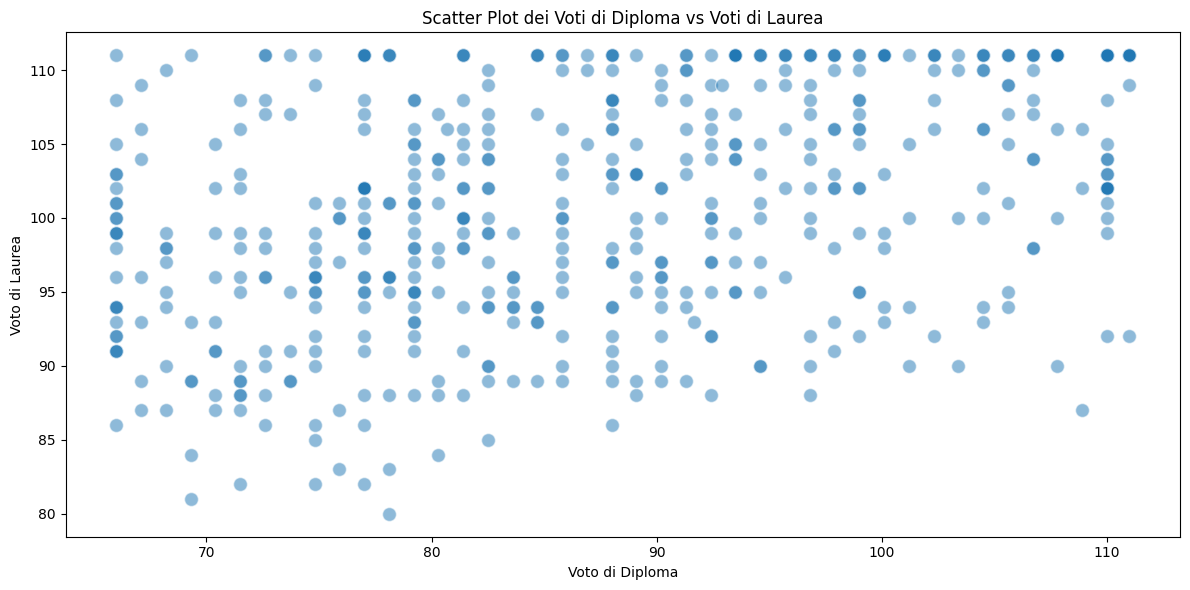

In [442]:
plt.figure(figsize=(12, 6))

plt.scatter(pt_val_finale['VOTO_DIPLOMA'], pt_val_finale['VOTO_LAUREA'], alpha=0.5, edgecolors='w', s=100)
plt.xlabel('Voto di Diploma')
plt.ylabel('Voto di Laurea')
plt.title('Scatter Plot dei Voti di Diploma vs Voti di Laurea')

plt.tight_layout()
plt.show()


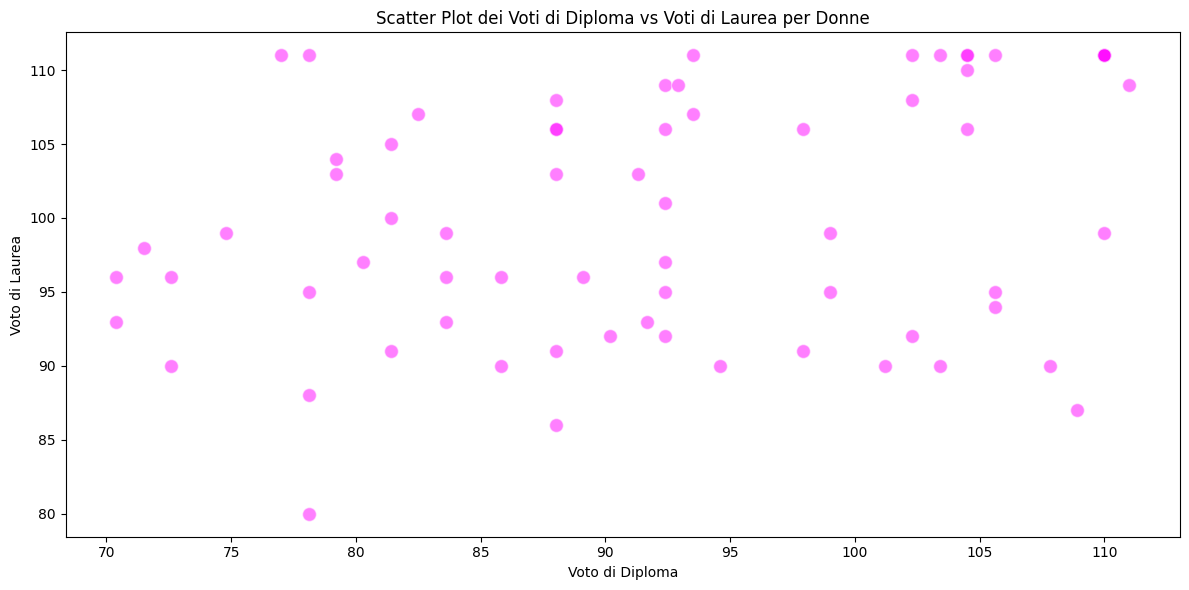

In [443]:
plt.figure(figsize=(12, 6))

plt.scatter(pt_val_finale[pt_val_finale['GENERE'] == 'F']['VOTO_DIPLOMA'],
            pt_val_finale[pt_val_finale['GENERE'] == 'F']['VOTO_LAUREA'],
            color='magenta', alpha=0.5, edgecolors='w', s=100)
plt.xlabel('Voto di Diploma')
plt.ylabel('Voto di Laurea')
plt.title('Scatter Plot dei Voti di Diploma vs Voti di Laurea per Donne')

plt.tight_layout()
plt.show()


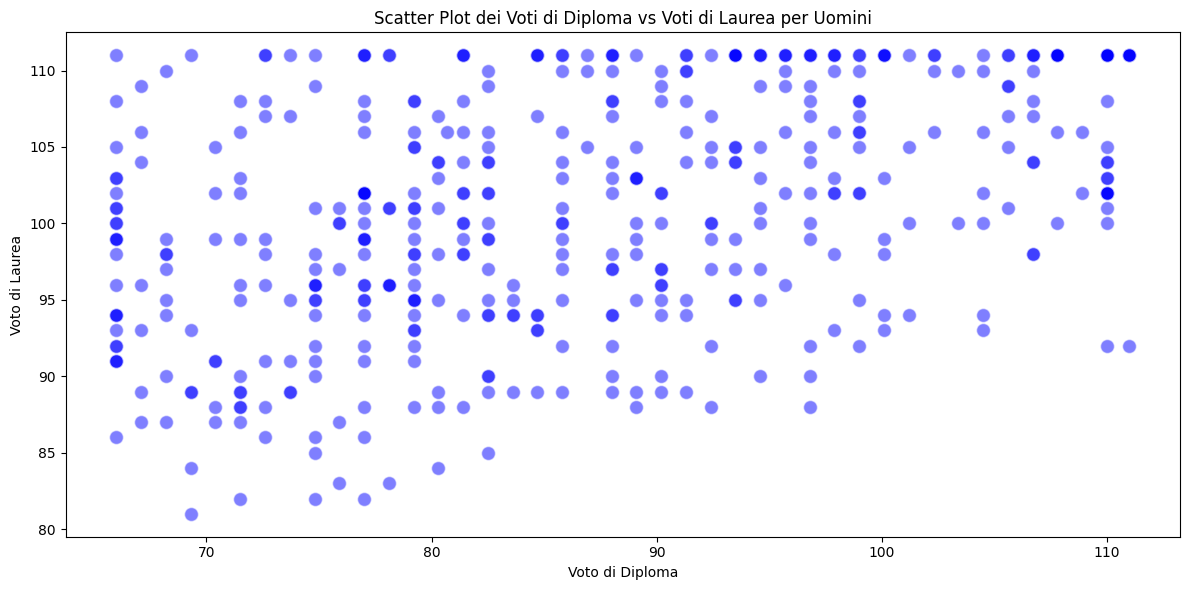

In [444]:
plt.figure(figsize=(12, 6))

plt.scatter(pt_val_finale[pt_val_finale['GENERE'] == 'M']['VOTO_DIPLOMA'],
            pt_val_finale[pt_val_finale['GENERE'] == 'M']['VOTO_LAUREA'],
            color='blue', alpha=0.5, edgecolors='w', s=100)
plt.xlabel('Voto di Diploma')
plt.ylabel('Voto di Laurea')
plt.title('Scatter Plot dei Voti di Diploma vs Voti di Laurea per Uomini')

plt.tight_layout()
plt.show()


### Voti per anno

Ci sono solo 35 esami registrati dal 97 al 2010, <br>
inoltre facendo merge con il database delle lauree perdo i dati

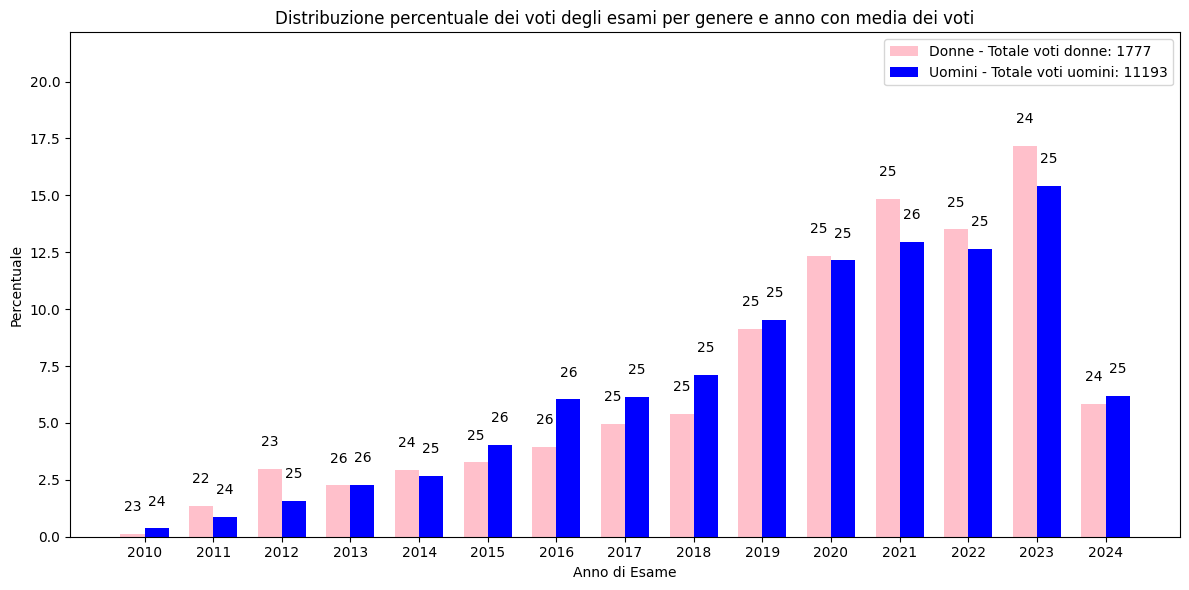

In [445]:
totale_voti_donne = len(pt[pt['GENERE'] == 'F'])
totale_voti_uomini = len(pt[pt['GENERE'] == 'M'])

percentuali_donne = pt[pt['GENERE'] == 'F']['ANNO_ESAME'].value_counts(normalize=True) * 100
percentuali_uomini = pt[pt['GENERE'] == 'M']['ANNO_ESAME'].value_counts(normalize=True) * 100

anni = sorted(set(percentuali_donne.index).union(set(percentuali_uomini.index)))

percentuali_donne = percentuali_donne.reindex(anni, fill_value=0)
percentuali_uomini = percentuali_uomini.reindex(anni, fill_value=0)

media_voti_donne = pt[pt['GENERE'] == 'F'].groupby('ANNO_ESAME')['VOTO'].mean()
media_voti_uomini = pt[pt['GENERE'] == 'M'].groupby('ANNO_ESAME')['VOTO'].mean()
media_voti_donne = media_voti_donne.reindex(anni, fill_value=0)
media_voti_uomini = media_voti_uomini.reindex(anni, fill_value=0)

bar_width = 0.35
r1 = np.arange(len(anni))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))

plt.bar(r1, percentuali_donne, label=f'Donne - Totale voti donne: {totale_voti_donne}', color='pink', width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini - Totale voti uomini: {totale_voti_uomini}', color='blue', width=bar_width)

for i, anno in enumerate(anni):
    media_voto_donne = int(round(media_voti_donne[anno], 0))
    media_voto_uomini = int(round(media_voti_uomini[anno], 0))
    plt.text(r1[i], percentuali_donne[anno] + 1, f'{media_voto_donne:d}', ha='center', fontsize=10)
    plt.text(r2[i], percentuali_uomini[anno] + 1, f'{media_voto_uomini:d}', ha='center', fontsize=10)

plt.xlabel('Anno di Esame')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti degli esami per genere e anno con media dei voti')
plt.xticks(r1 + bar_width / 2, anni)
plt.ylim(0, max(percentuali_donne.max(), percentuali_uomini.max()) + 5)
plt.legend()

plt.tight_layout()
plt.show()


### Voti in due anni specifici

Ho usato 2012, 13 e 14 per avere lo stesso numero di campioni di 2018

In [446]:
esami12e13e14 = pt[(pt['ANNO_ESAME'] == 2012) | (pt['ANNO_ESAME'] == 2013) | (pt['ANNO_ESAME'] == 2014)]
esami2018 = pt[pt['ANNO_ESAME'] == 2018]

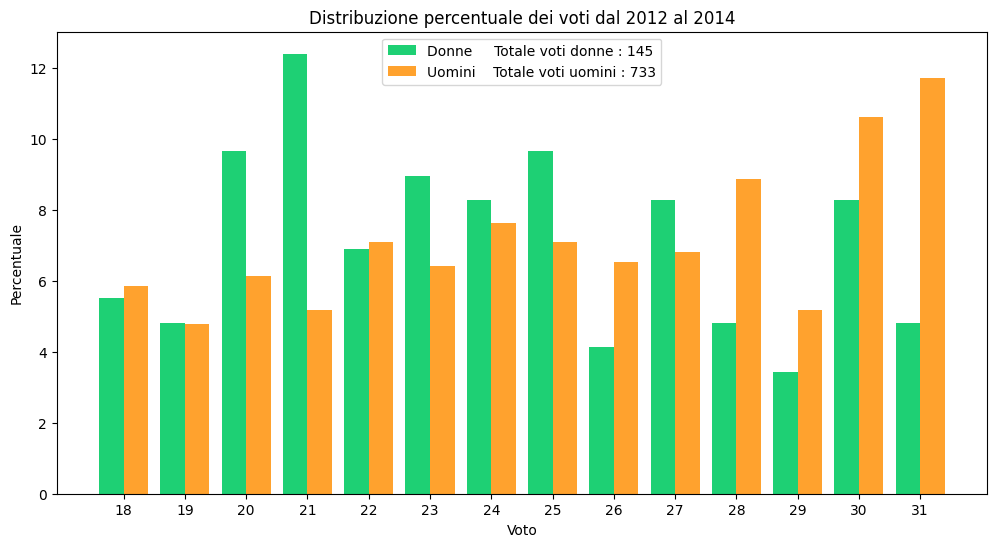

In [447]:
# visualizzazione della percentuale dei voti nel 2012,2013,2014

totale_voti_donne = len(esami12e13e14[esami12e13e14['GENERE'] == 'F'])
totale_voti_uomini = len(esami12e13e14[esami12e13e14['GENERE'] == 'M'])

voti_donne = esami12e13e14[esami12e13e14['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami12e13e14[esami12e13e14['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti dal 2012 al 2014')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()

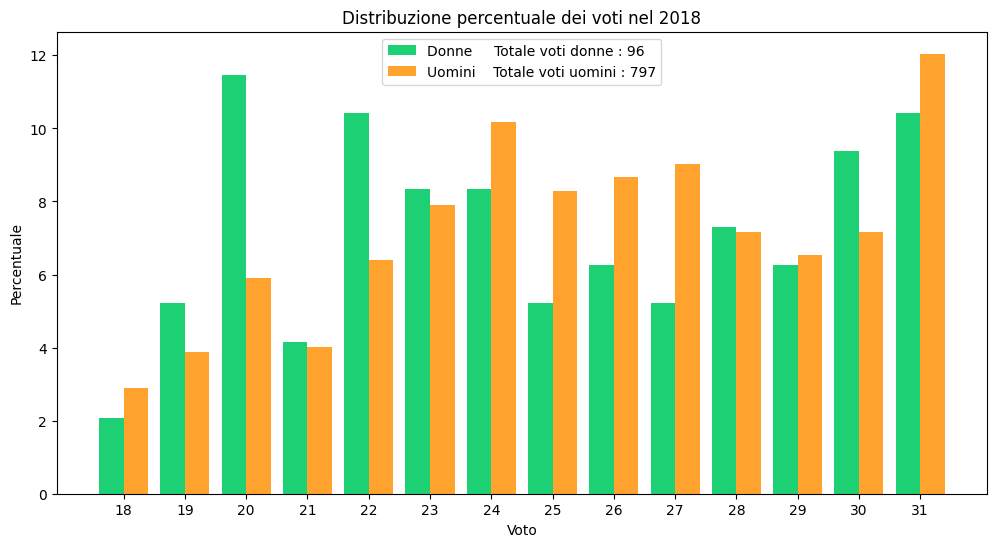

In [448]:
# visualizzazione della percentuale dei voti nel 2018

totale_voti_donne = len(esami2018[esami2018['GENERE'] == 'F'])
totale_voti_uomini = len(esami2018[esami2018['GENERE'] == 'M'])

voti_donne = esami2018[esami2018['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami2018[esami2018['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti nel 2018')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()

### Periodo preciso, pandemia
analizzo un periodo temporale preciso, il periodo di pandemia, in cui le modalità di esame sono cambiate per tutti gli insegnamenti <br>
inizio: 11 marzo 2020 <br>
non ho una data precisa della fine del periodo, perchè dipende dall'università, dal dipartimento e dal singolo professore <br>
indicativamente le sessioni con modalità d'esame completamente online sono state quelle estive giugno, luglio, settemrbe) del 2020 e quella invernale (gennaio, febbraio) del 2021 <br>
questo per quanto riguarda il dipartimento di informatica, <br>
successivamente alcuni professori hanno mantenuto alcune modalità online, come quiz o orali

In [449]:
# periodo pandemia : marzo 2020 - marzo 2021

data_inizio = '2020-03-11' #anno-mese-giorno
data_fine = '2021-03-11'
periodo_pandemia = pt[pt['DATA_ESAME'].between(data_inizio, data_fine)]

NON_periodo_pandemia = pt[~pt['DATA_ESAME'].between(data_inizio, data_fine)]

In [450]:
media_voti = round(pt['VOTO'].mean(), 2)
media_voti_p_p = round(periodo_pandemia['VOTO'].mean(), 2)
media_voti_N_p_p = round(NON_periodo_pandemia['VOTO'].mean(), 2)

print(f"Media valutazioni: {media_voti}")
print(f"Media valutazioni periodo di pandemia: {media_voti_p_p}")
print(f"Media valutazioni escluso il periodo di pandemia: {media_voti_N_p_p}")


Media valutazioni: 25.18
Media valutazioni periodo di pandemia: 25.0
Media valutazioni escluso il periodo di pandemia: 25.21


Le medie si discostano in modo NON significativo nei diversi periodi

In [451]:
donne = pt[pt['GENERE'] == 'F']
uomini = pt[pt['GENERE'] == 'M']

donne_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']
uomini_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']

print("Media valutazioni")
media_voti = round(donne['VOTO'].mean(), 2)
print(f"Donne: {media_voti}")
media_voti = round(uomini['VOTO'].mean(), 2)
print(f"Uomini: {media_voti}")
print()
print("Media valutazioni periodo di pandemia")
media_voti_p_p = round(donne_p_p['VOTO'].mean(), 2)
print(f"Donne: {media_voti_p_p}")
media_voti_p_p = round(uomini_p_p['VOTO'].mean(), 2)
print(f"Uomini: {media_voti_p_p}")

Media valutazioni
Donne: 24.75
Uomini: 25.25

Media valutazioni periodo di pandemia
Donne: 24.54
Uomini: 25.08


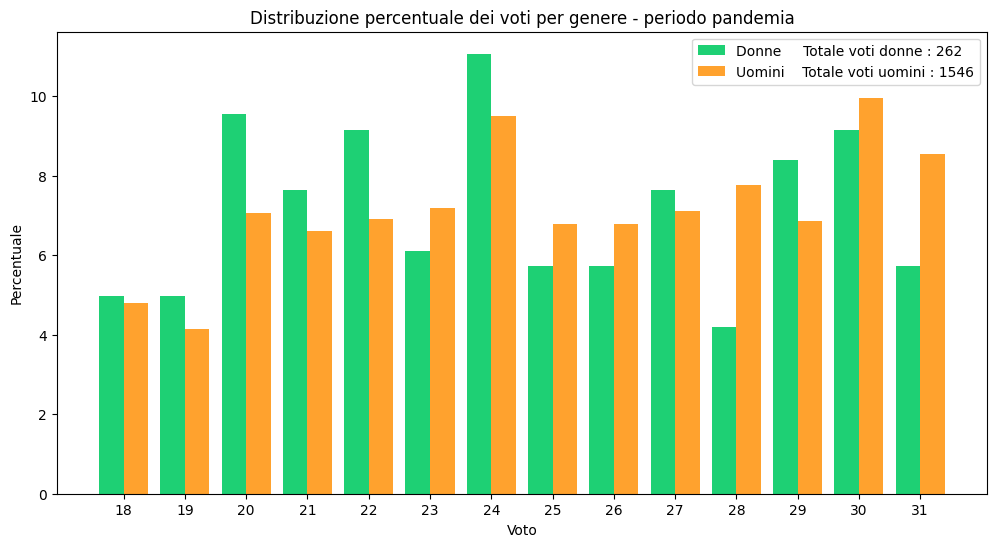

In [452]:
# visualizzazione della percentuale dei voti per genere
totale_voti_donne = len(periodo_pandemia[periodo_pandemia['GENERE'] == 'F'])
totale_voti_uomini = len(periodo_pandemia[periodo_pandemia['GENERE'] == 'M'])

voti_donne = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / len(periodo_pandemia[periodo_pandemia['GENERE'] == 'F'])) * 100
percentuale_voti_uomini = (voti_uomini / len(periodo_pandemia[periodo_pandemia['GENERE'] == 'M'])) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - periodo pandemia')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


### Il periodo di pandemia ha inciso in generale sui singoli voti
In generale è aumentato il divario di genere guardando singolarmente i voti <br>
L'andamento degli uomini è cambiato meno rispetto a quello delle donne <br> -- non so se posso affermarlo stando a questi dati
per le donne sono diminuiti i 18 e aumentati i 20, 22, 24 <br>
Per gli uomini sono aumentati i 32 <br>

In generale le valutazioni si sono alzate, ma la media è rimasta costante
Questi risultati possono essere dati dalla scarsità del campione per quanto riguarda le donne

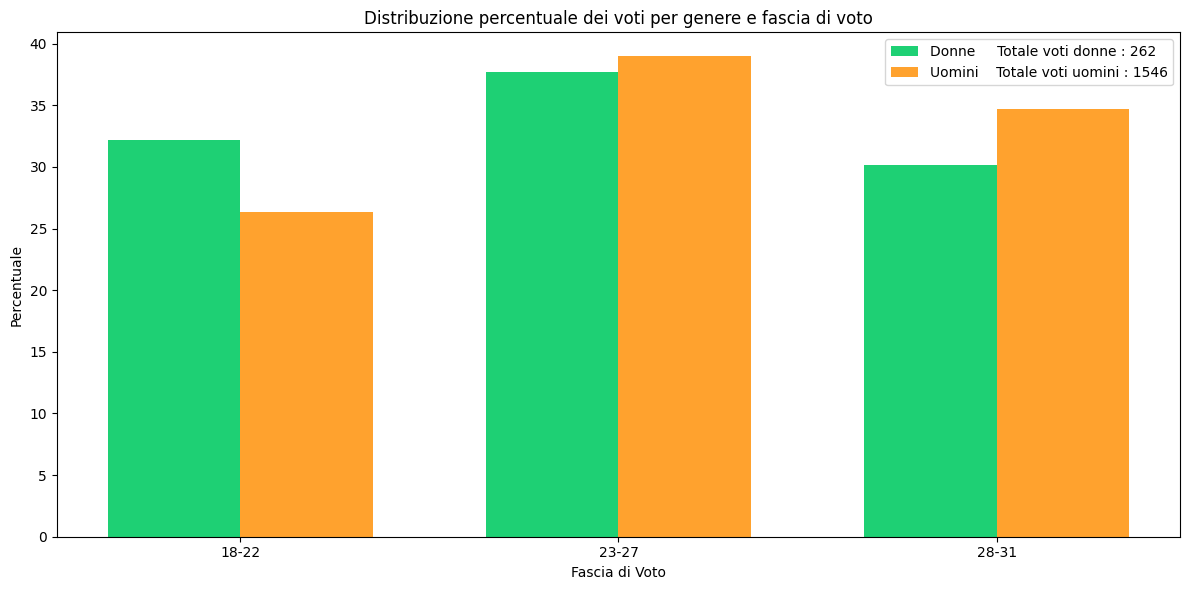

In [453]:
totale_voti = pt_vecchi.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


### Analizzo singolarmente alcuni insegnamenti con una sola modalità di esame
Assumo che anche i vecchi insegnamenti avessero le modalità riportate<br>
<br>
Esami orali: 
<br>
<b>SETI</b>: quiz sbarramento + orale <br>
<b>APA</b>: scritto sbarramento + orale di 2 professori <br>
<b>SAW</b>:  domande sbarramento + orale progetto <br>
<b>TAC</b>: scritto sbarramento + orale <br>
<b>FCQ</b>: solo orale <br>


<br>
Esami scritti: <br>
<b>Algebra e logica</b>: 2 scritti <br>
<b>ALAN</b>: due scritti <br>
<b>TDII</b>: solo scritto <br>
<b>CALCULUS2</b>: solo scritto <br>
<b>CS</b>: solo scritto <br>
<b>PCAD</b>: solo scritto<br>
<b>FIS</b>: quiz sbarramento + due scritti <br>


In [454]:
# orali
media_orali = round(esami_orali['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali: {media_orali}")

donne = esami_orali[esami_orali['GENERE'] == 'F']
media_orali = round(donne['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali delle donne: {media_orali}")

uomini = esami_orali[esami_orali['GENERE'] == 'M']
media_orali = round(uomini['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali degli uomini: {media_orali}")

# scritti
media_scritti = round(esami_scritti['VOTO'].mean(), 2)
print(f"Media valutazioni esami scritti: {media_scritti}")

donne = esami_scritti[esami_scritti['GENERE'] == 'F']
media_scritti = round(donne['VOTO'].mean(), 2)
print(f"Media valutazioni esami scritti delle donne: {media_scritti}")

uomini = esami_scritti[esami_scritti['GENERE'] == 'M']
media_scritti = round(uomini['VOTO'].mean(), 2)
print(f"Media valutazioni esami scritti degli uomini: {media_scritti}")

Media valutazioni esami orali: 25.83
Media valutazioni esami orali delle donne: 25.57
Media valutazioni esami orali degli uomini: 25.87
Media valutazioni esami scritti: 24.17
Media valutazioni esami scritti delle donne: 23.65
Media valutazioni esami scritti degli uomini: 24.26


la media si discosta più tra scritti e orali rispetto che alla differenza di genere

/tmp/ipykernel_4624/2444232092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esami_scritti['TIPO_ESAME'] = 'SCRITTI'
/tmp/ipykernel_4624/2444232092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esami_orali['TIPO_ESAME'] = 'ORALI'


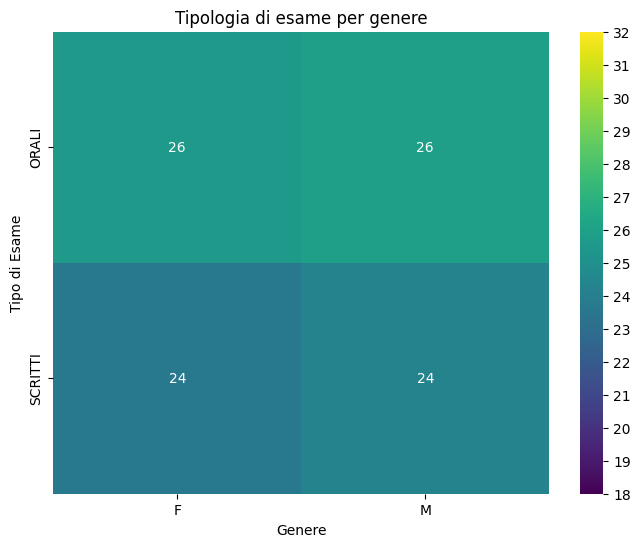

In [455]:
# creo nuovo db esami per non gestire null
esami_scritti['TIPO_ESAME'] = 'SCRITTI'
esami_orali['TIPO_ESAME'] = 'ORALI'
esami = pd.concat([esami_scritti, esami_orali])

pivot_table = esami.pivot_table(values='VOTO', index='TIPO_ESAME', columns='GENERE', aggfunc='mean')
cbar_kws = {'ticks': range(18, 33)}
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(pivot_table, annot=True, cmap='viridis', vmin=18, vmax=32, cbar_kws=cbar_kws)
heatmap.set_title('Tipologia di esame per genere')
plt.xlabel('Genere')
plt.ylabel('Tipo di Esame')
plt.show()

La differenza delle medie non è significativa, la media delle donne è sempre leggermente inferiore a quella maschile
E' maggiormente evidente che la media degli scritti è inferiore a quella degli orali

### Esami orali

In [456]:
esami_orali['ANNO_ESAME'].unique()

array([2015, 2016, 2017, 2021, 2018, 2019, 2022, 2020, 2023, 2024],
      dtype=int32)

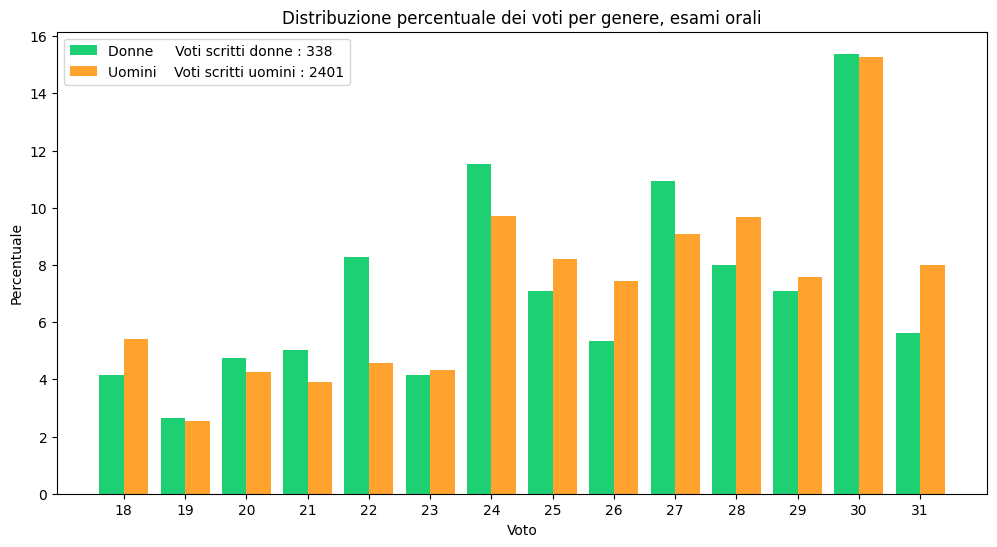

In [457]:
# distribuzione dei voti orali

totale_voti_donne = len(esami_orali[esami_orali['GENERE'] == 'F'])
totale_voti_uomini = len(esami_orali[esami_orali['GENERE'] == 'M'])
voti_donne = esami_orali[esami_orali['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami_orali[esami_orali['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Voti scritti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Voti scritti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami orali')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


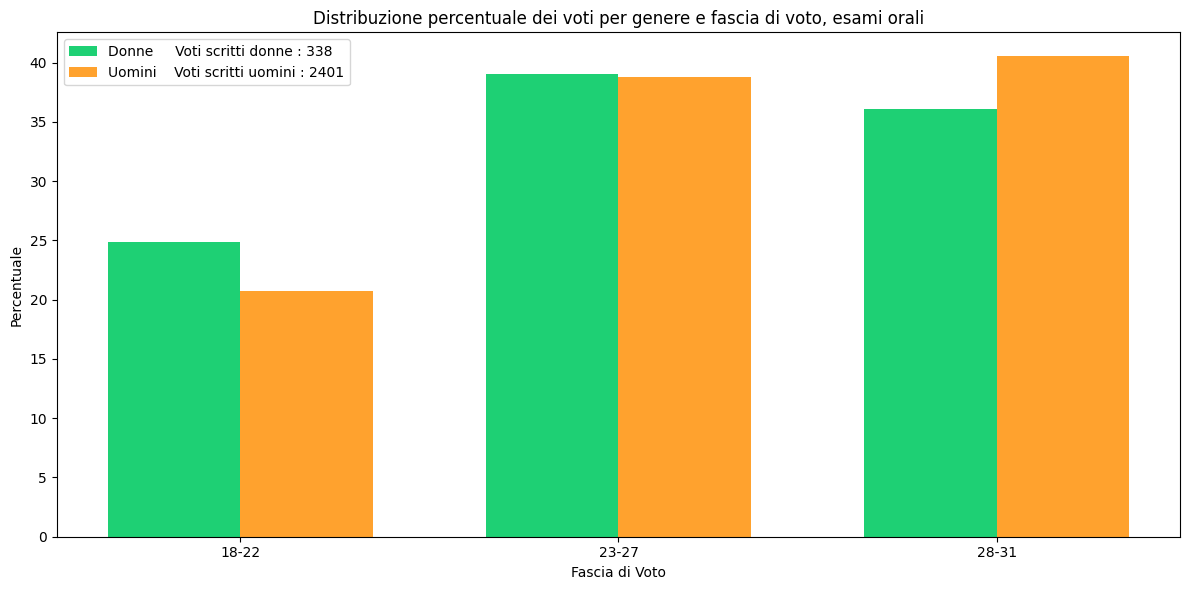

In [458]:
totale_voti = esami_orali.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label=f'Donne     Voti scritti donne : {totale_voti_donne}', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini    Voti scritti uomini : {totale_voti_uomini}', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto, esami orali')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()

### Esami scritti

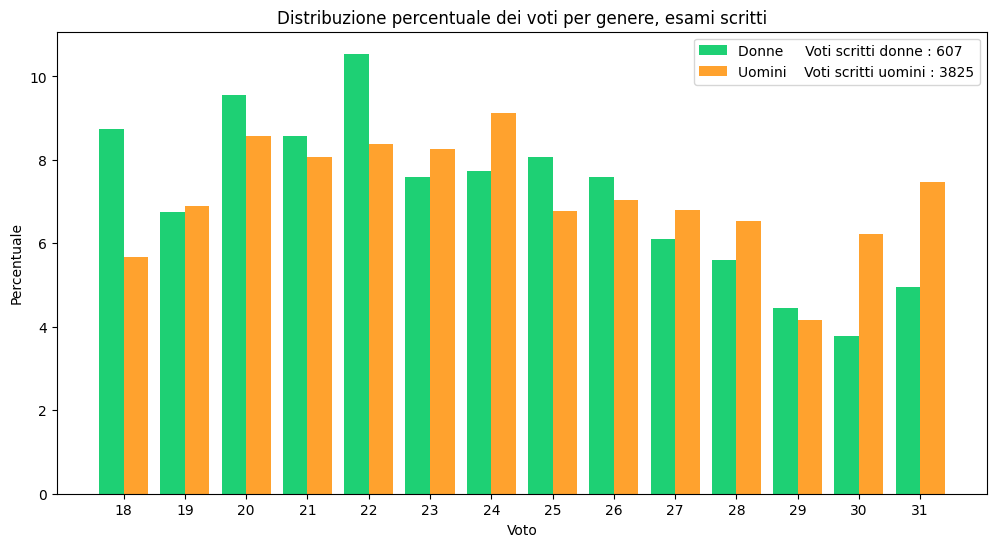

In [459]:
# distribuzione dei voti scritti

totale_voti_donne = len(esami_scritti[esami_scritti['GENERE'] == 'F'])
totale_voti_uomini = len(esami_scritti[esami_scritti['GENERE'] == 'M'])
voti_donne = esami_scritti[esami_scritti['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami_scritti[esami_scritti['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Voti scritti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Voti scritti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami scritti')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


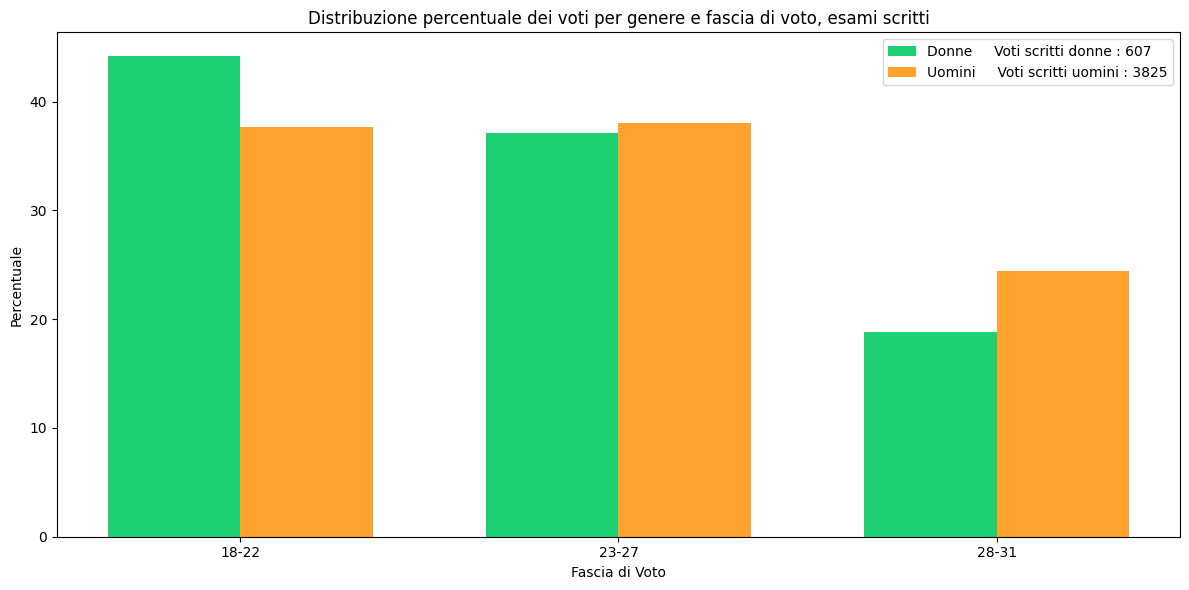

In [460]:
totale_voti = esami_scritti.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label=f'Donne     Voti scritti donne : {totale_voti_donne}', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label=f'Uomini     Voti scritti uomini : {totale_voti_uomini}', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto, esami scritti')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


### Singoli esami

Ordine sulle slide
ALGORITMI E STRUTTURE DATI
CALCULUS 2

In [461]:
# Analizzo un esame in particolare

# sbilanciati
# TECNICHE AVANZATE DI PROGRAMMAZIONE
# CALCULUS 2 
# SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE

# bilanciati
# ALGORITMI E STRUTTURE DATI

nome_esame = 'TECNICHE AVANZATE DI PROGRAMMAZIONE'

In [462]:
esame_singolo = dopo15_vecchi[(dopo15_vecchi['DECODIFICA_INS'] == nome_esame)]

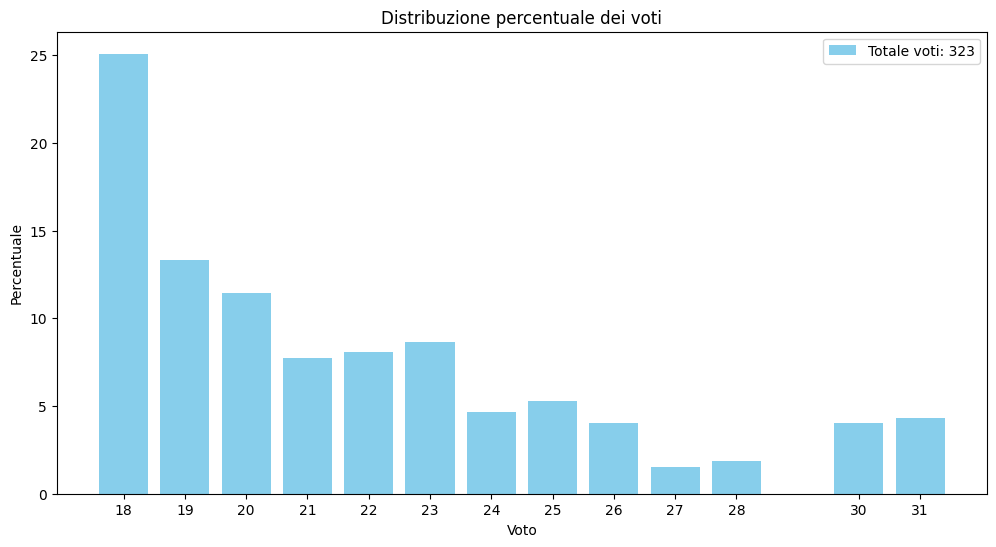

In [463]:
totale_voti = len(esame_singolo)
voti = esame_singolo['VOTO'].value_counts().sort_index()

percentuale_voti = (voti / totale_voti) * 100

plt.figure(figsize=(12, 6))
plt.legend([f'Totale voti: {totale_voti}'])
plt.bar(voti.index, percentuale_voti, color='skyblue', label=f'Totale voti: {totale_voti}')
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti')
plt.xticks(voti.index)

plt.legend()
plt.show()

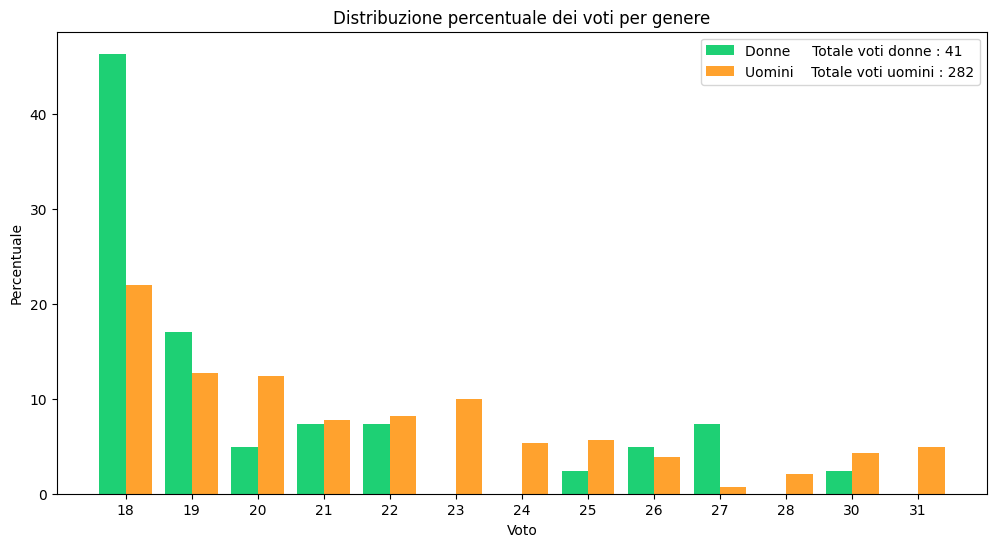

In [464]:
totale_voti_donne = len(esame_singolo[esame_singolo['GENERE'] == 'F'])
totale_voti_uomini = len(esame_singolo[esame_singolo['GENERE'] == 'M'])
voti_donne = esame_singolo[esame_singolo['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esame_singolo[esame_singolo['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color= colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.legend()
plt.show()

### Analisi distribuzione dei voti per anno dell'insegnamento

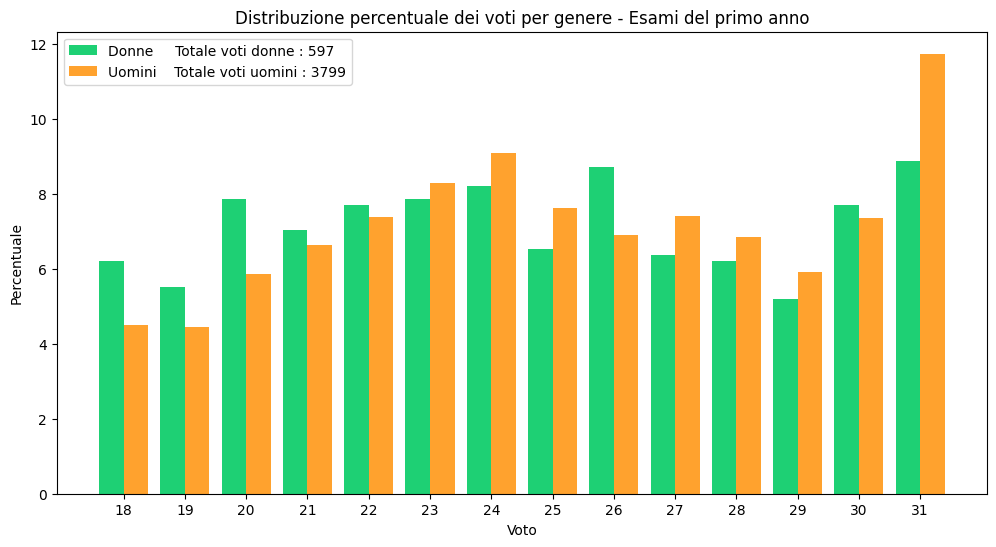

In [465]:
# primo anno

totale_voti_donne = len(primo_anno[primo_anno['GENERE'] == 'F'])
totale_voti_uomini = len(primo_anno[primo_anno['GENERE'] == 'M'])

voti_donne = primo_anno[primo_anno['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = primo_anno[primo_anno['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - Esami del primo anno')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()

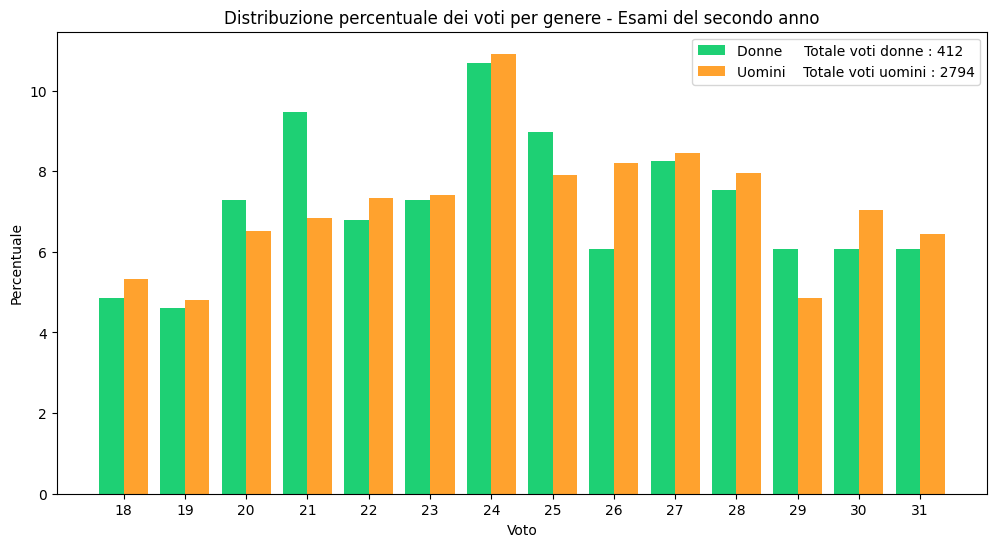

In [466]:
# secondo anno

totale_voti_donne = len(secondo_anno[secondo_anno['GENERE'] == 'F'])
totale_voti_uomini = len(secondo_anno[secondo_anno['GENERE'] == 'M'])

voti_donne = secondo_anno[secondo_anno['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = secondo_anno[secondo_anno['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - Esami del secondo anno')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()

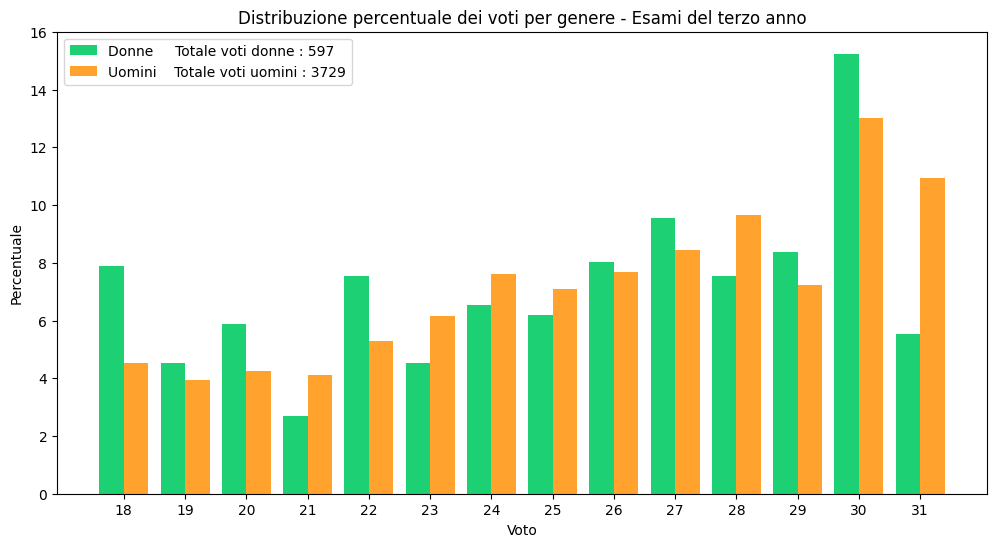

In [467]:
# terzo anno

totale_voti_donne = len(terzo_anno[terzo_anno['GENERE'] == 'F'])
totale_voti_uomini = len(terzo_anno[terzo_anno['GENERE'] == 'M'])

voti_donne = terzo_anno[terzo_anno['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = terzo_anno[terzo_anno['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - Esami del terzo anno')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()

### Analisi in base al genere dei docenti

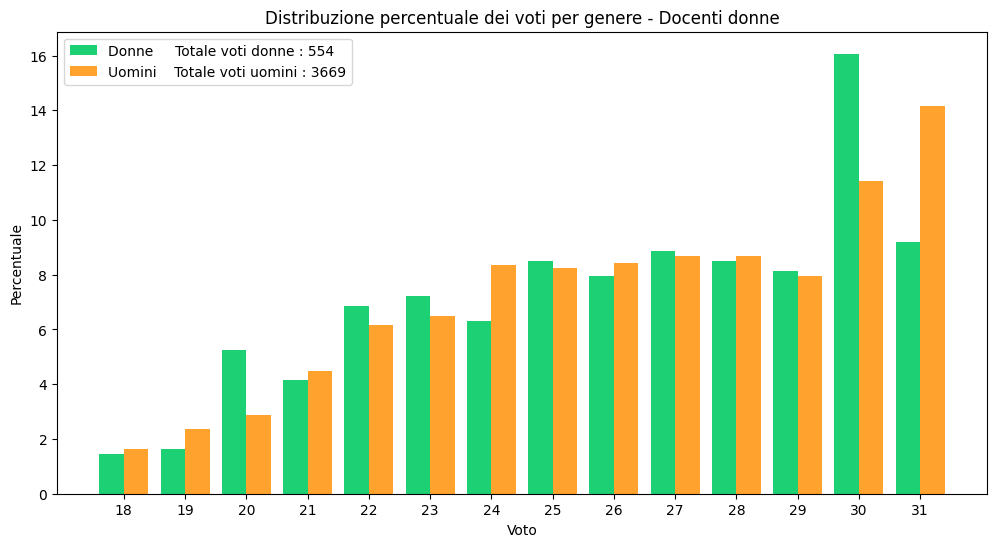

In [468]:
# docenti di genere femminile

totale_voti_donne = len(docenti_donne[docenti_donne['GENERE'] == 'F'])
totale_voti_uomini = len(docenti_donne[docenti_donne['GENERE'] == 'M'])

voti_donne = docenti_donne[docenti_donne['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = docenti_donne[docenti_donne['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - Docenti donne')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()

# docenti donne: 4 scritti, 3 orali, 2 misti
# docenti uomini: 8 scritti, 3 orali, 1 misto

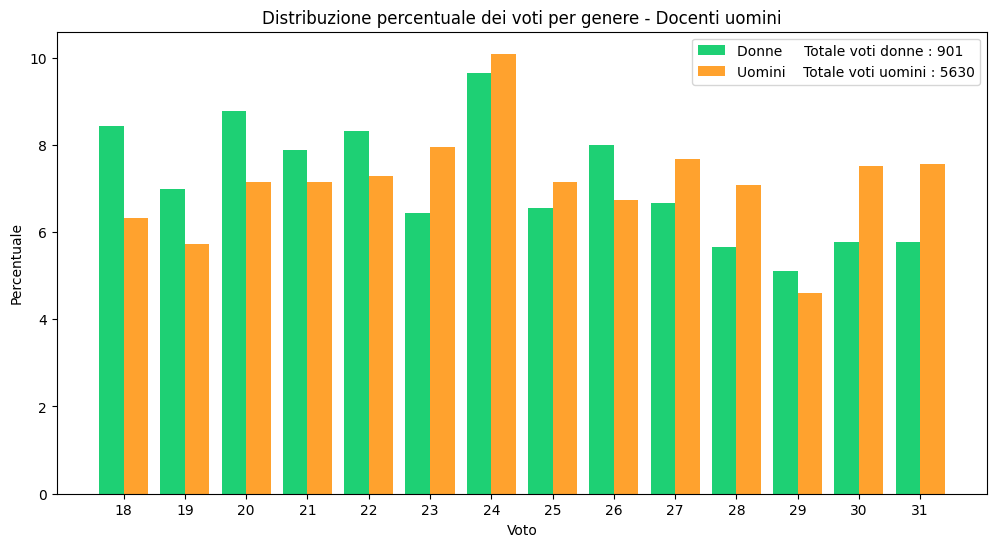

In [469]:
# docenti di genere maschile

totale_voti_donne = len(docenti_uomini[docenti_uomini['GENERE'] == 'F'])
totale_voti_uomini = len(docenti_uomini[docenti_uomini['GENERE'] == 'M'])

voti_donne = docenti_uomini[docenti_uomini['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = docenti_uomini[docenti_uomini['GENERE'] == 'M']['VOTO'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - Docenti uomini')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()

# docenti donne: 4 scritti, 3 orali, 2 misti
# docenti uomini: 8 scritti, 3 orali, 1 misto

### Lodi

In [470]:
#pt['DATA_LAUREA'].min()
pt['DATA_LAUREA'].max()

Timestamp('2024-03-26 00:00:00')

In [471]:
totale_lauree = len(pt[pt['VOTO_LAUREA'].notna()]['PROGRESSIVO'].unique())
totale_lodi= len(pt[(pt['DATA_LAUREA'].notna() & (pt['VOTO_LAUREA'] == 111))]['PROGRESSIVO'].unique())
numero_lodi_donne = len(pt[(pt['DATA_LAUREA'].notna() & (pt['VOTO_LAUREA'] == 111) & (pt['GENERE'] == 'F'))]['PROGRESSIVO'].unique())
numero_lodi_uomini = len(pt[(pt['DATA_LAUREA'].notna() & (pt['VOTO_LAUREA'] == 111) & (pt['GENERE'] == 'M'))]['PROGRESSIVO'].unique())
totale_lauree_donne = len(pt[(pt['DATA_LAUREA'].notna() & (pt['GENERE'] == 'F'))]['PROGRESSIVO'].unique())
totale_lauree_uomini = len(pt[(pt['DATA_LAUREA'].notna() & (pt['GENERE'] == 'M'))]['PROGRESSIVO'].unique())

perc = (totale_lodi * 100) / (totale_lauree)
print(f'Percentuale lodi su lauree: {perc}')

perc = (numero_lodi_donne * 100) / (totale_lauree_donne)
print(f'Percentuale di lauree con lode di donne sulle donne laureate: {perc}')

perc = (numero_lodi_uomini * 100) / (totale_lauree_uomini)
print(f'Percentuale di lauree con lode di uomini sulle uomini laureate: {perc}')

perc = (numero_lodi_donne * 100) / (totale_lodi)
print(f'Percentuale di lauree con lode di donne sulle lauree con lode: {perc}')

print(f'{numero_lodi_donne} lauree con lode di donne in 12 anni')
print(f'{numero_lodi_uomini} lauree con lode di uomini in 12 anni')



Percentuale lodi su lauree: 18.71559633027523
Percentuale di lauree con lode di donne sulle donne laureate: 16.216216216216218
Percentuale di lauree con lode di uomini sulle uomini laureate: 19.10828025477707
Percentuale di lauree con lode di donne sulle lauree con lode: 11.764705882352942
12 lauree con lode di donne in 12 anni
90 lauree con lode di uomini in 12 anni


In [472]:
totale_voti = len(pt)
totale_lodi= len(pt[pt['VOTO'] == 31])
numero_lodi_donne = len(pt[(pt['GENERE'] == 'F') & (pt['VOTO'] == 31)])
numero_lodi_uomini = len(pt[(pt['GENERE'] == 'M') & (pt['VOTO'] == 31)])
totale_voti_donne = len(pt[pt['GENERE'] == 'F'])
totale_voti_uomini = len(pt[pt['GENERE'] == 'M'])

perc = (totale_lodi * 100) / (totale_voti)
print(f'Percentuale lodi su voti: {perc}')

perc = (numero_lodi_donne * 100) / (totale_voti_donne)
print(f'Percentuale di esami di donne con lode sugli esami delle donne: {perc}')

perc = (numero_lodi_uomini * 100) / (totale_voti_uomini)
print(f'Percentuale di esami di uomini con lode sugli esami delle uomini: {perc}')

perc = (numero_lodi_donne * 100) / (totale_lodi)
print(f'Percentuale di esami di donne con lode sulle lodi: {perc}')

print(f'{numero_lodi_donne} esami di donne con lode in 12 anni')
print(f'{numero_lodi_uomini} esami di uomini con lode in 12 anni')



Percentuale lodi su voti: 9.645335389360062
Percentuale di esami di donne con lode sugli esami delle donne: 6.640405177265054
Percentuale di esami di uomini con lode sugli esami delle uomini: 10.122397927275976
Percentuale di esami di donne con lode sulle lodi: 9.432454036770583
118 esami di donne con lode in 12 anni
1133 esami di uomini con lode in 12 anni


Ricordiamo l'andamento degli esami scritti o orali per verificare se hanno inciso

### Valutazioni Basi di Dati

In [473]:
# pulizia
basi_di_dati = basi_di_dati.dropna(subset=['Quiz'])
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].astype(int)
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({12: 17})
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({13: 17})
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({14: 17})
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({15: 17})
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({16: 17})

basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({32: 31})
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({33: 31})
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({34: 31})
basi_di_dati['Quiz'] = basi_di_dati['Quiz'].replace({35: 31})

basi_di_dati = basi_di_dati.dropna(subset=['Scritto su carta'])
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].astype(int)
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({12: 17})
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({13: 17})
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({14: 17})
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({15: 17})
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({16: 17})

basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({32: 31})
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({33: 31})
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({34: 31})
basi_di_dati['Scritto su carta'] = basi_di_dati['Scritto su carta'].replace({35: 31})

basi_di_dati = basi_di_dati.dropna(subset=['Progetto'])

basi_di_dati = basi_di_dati[basi_di_dati['Progetto'] != 'riconsegnare']
basi_di_dati = basi_di_dati[basi_di_dati['Progetto'] != 0]
#basi_di_dati = basi_di_dati[basi_di_dati['Progetto'] != 'no parte 3']
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({'no parte 3': 17})

basi_di_dati['Progetto'] = basi_di_dati['Progetto'].astype(int)
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({12: 17})
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({13: 17})
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({14: 17})
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({15: 17})
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({16: 17})

basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({32: 31})
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({33: 31})
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({34: 31})
basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({35: 31})



/tmp/ipykernel_4624/1826934062.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  basi_di_dati['Progetto'] = basi_di_dati['Progetto'].replace({'no parte 3': 17})


In [474]:
# quiz
media_quiz = round(basi_di_dati['Quiz'].mean(), 2)
print(f"Media valutazioni esami quiz: {media_quiz}")

donne = basi_di_dati[basi_di_dati['GENERE'] == 'F']
media_quiz = round(donne['Quiz'].mean(), 2)
print(f"Media valutazioni esami quiz delle donne: {media_quiz}")

uomini = basi_di_dati[basi_di_dati['GENERE'] == 'M']
media_quiz = round(uomini['Quiz'].mean(), 2)
print(f"Media valutazioni esami quiz degli uomini: {media_quiz}")

# scritti
media_scritto = round(basi_di_dati['Scritto su carta'].mean(), 2)
print(f"Media valutazioni esami scritti: {media_scritto}")

donne = basi_di_dati[basi_di_dati['GENERE'] == 'F']
media_scritto = round(donne['Scritto su carta'].mean(), 2)
print(f"Media valutazioni esami scritti delle donne: {media_scritto}")

uomini = basi_di_dati[basi_di_dati['GENERE'] == 'M']
media_scritto = round(uomini['Scritto su carta'].mean(), 2)
print(f"Media valutazioni esami scritti degli uomini: {media_scritto}")

# progetto
media_progetto = round(basi_di_dati['Progetto'].mean(), 2)
print(f"Media valutazioni progetto: {media_progetto}")

donne = basi_di_dati[basi_di_dati['GENERE'] == 'F']
media_progetto_d = round(donne['Progetto'].mean(), 2)
print(f"Media valutazioni progetto delle donne: {media_progetto_d}")

uomini = basi_di_dati[basi_di_dati['GENERE'] == 'M']
media_progetto_u = round(uomini['Progetto'].mean(), 2)
print(f"Media valutazioni progetto degli uomini: {media_progetto_u}")

Media valutazioni esami quiz: 24.65
Media valutazioni esami quiz delle donne: 24.1
Media valutazioni esami quiz degli uomini: 24.78
Media valutazioni esami scritti: 22.39
Media valutazioni esami scritti delle donne: 23.1
Media valutazioni esami scritti degli uomini: 22.22
Media valutazioni progetto: 25.58
Media valutazioni progetto delle donne: 25.71
Media valutazioni progetto degli uomini: 25.55


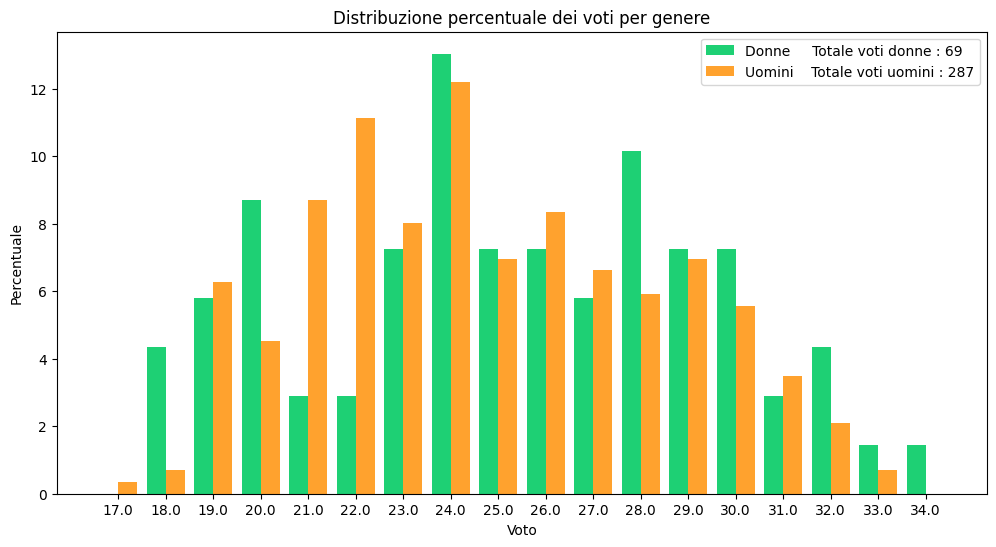

In [475]:
# visualizzazione della percentuale dei voti per genere

totale_voti_donne = len(basi_di_dati[basi_di_dati['GENERE'] == 'F'])
totale_voti_uomini = len(basi_di_dati[basi_di_dati['GENERE'] == 'M'])

voti_donne = basi_di_dati[basi_di_dati['GENERE'] == 'F']['Round'].value_counts().sort_index()
voti_uomini = basi_di_dati[basi_di_dati['GENERE'] == 'M']['Round'].value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


Quiz

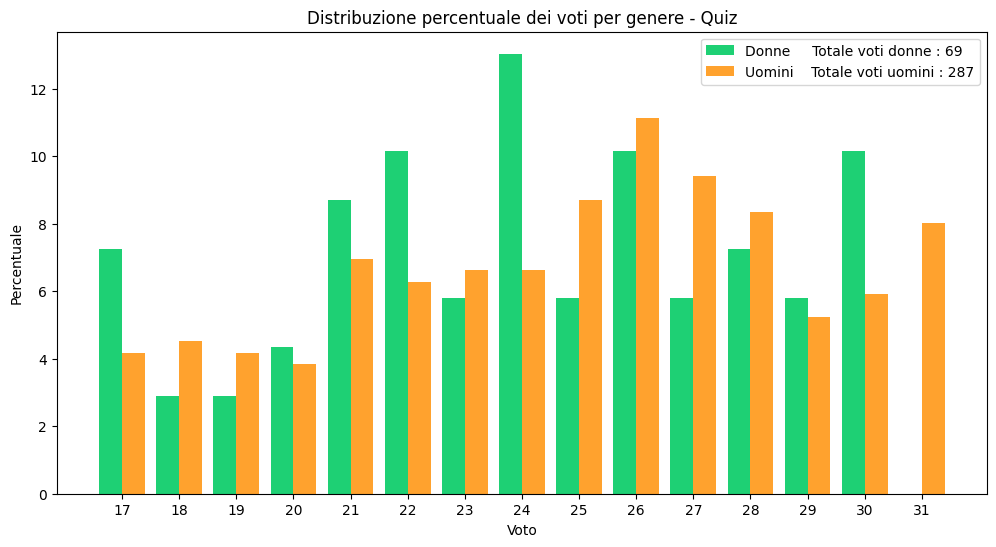

In [476]:
totale_voti_donne = len(basi_di_dati[basi_di_dati['GENERE'] == 'F'])
totale_voti_uomini = len(basi_di_dati[basi_di_dati['GENERE'] == 'M'])

voti_donne = round(basi_di_dati[basi_di_dati['GENERE'] == 'F']['Quiz']).value_counts().sort_index()
voti_uomini = round(basi_di_dati[basi_di_dati['GENERE'] == 'M']['Quiz']).value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - Quiz')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


Scritto

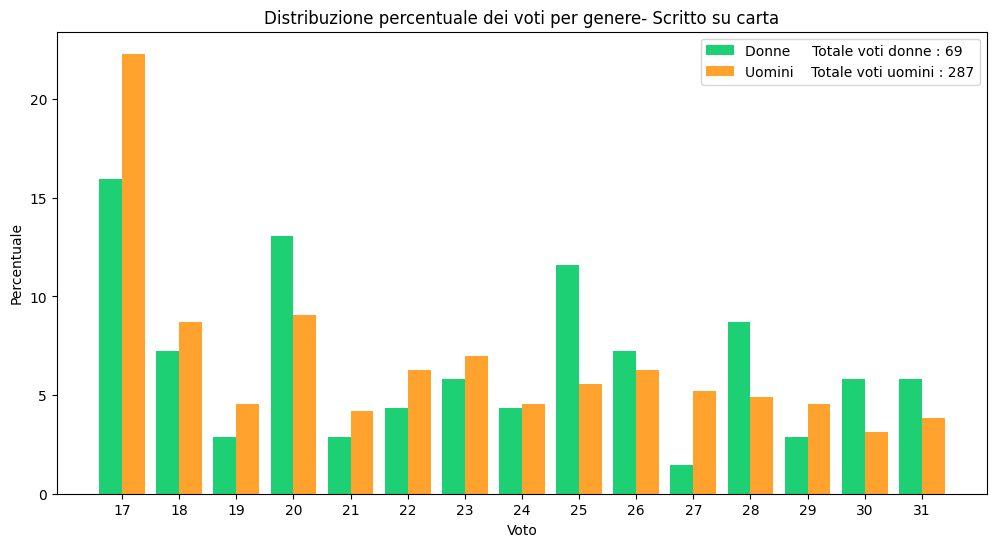

In [477]:
totale_voti_donne = len(basi_di_dati[basi_di_dati['GENERE'] == 'F'])
totale_voti_uomini = len(basi_di_dati[basi_di_dati['GENERE'] == 'M'])

voti_donne = round(basi_di_dati[basi_di_dati['GENERE'] == 'F']['Scritto su carta']).value_counts().sort_index()
voti_uomini = round(basi_di_dati[basi_di_dati['GENERE'] == 'M']['Scritto su carta']).value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere- Scritto su carta')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


Progetto

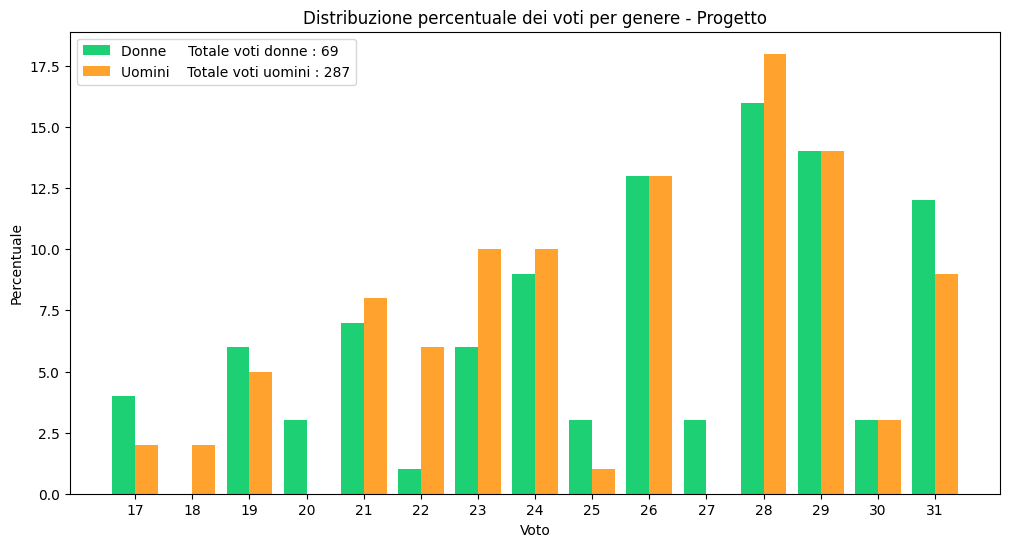

In [478]:
totale_voti_donne = len(basi_di_dati[basi_di_dati['GENERE'] == 'F'])
totale_voti_uomini = len(basi_di_dati[basi_di_dati['GENERE'] == 'M'])

voti_donne = round(basi_di_dati[basi_di_dati['GENERE'] == 'F']['Progetto']).value_counts().sort_index()
voti_uomini = round(basi_di_dati[basi_di_dati['GENERE'] == 'M']['Progetto']).value_counts().sort_index()

voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)

percentuale_voti_donne = round((voti_donne / totale_voti_donne) * 100)
percentuale_voti_uomini = round((voti_uomini / totale_voti_uomini) * 100)

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label=f'Donne     Totale voti donne : {totale_voti_donne}', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label=f'Uomini    Totale voti uomini : {totale_voti_uomini}', color=colore_uomini)

plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - Progetto')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


### Test statistici

Il test statistico calcola la probabilità che la mia ipotesi H0 sia vera<br>
Considero le ipotesi:<br>
H0 (ipotesi nulla): i test statistici NON hanno differenze significative<br>
HA (ipotesi complementare): i test statistici hanno differenze significative<br>

Ricorda
Il rifiuto dell’ipotesi nulla non prova che essa è vera. <br>
Si può concludere che non vi è sufficiente evidenza empirica contraria ad essa.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti dell’intera popolazione e quella delle ragazze <br>
(eventualmente come si diceva considerando solo i laureati)

In [479]:
dim_campione = len(pt[(pt['GENERE'] == 'F') & (pt['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione è : {dim_campione}")

dim_popolazione = len(pt[pt['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza della popolazione è : {dim_popolazione}")

L'ampiezza del campione è : 1777
L'ampiezza della popolazione è : 12970


In [480]:
# differenza tra voti e voti_donne, campioni indipendenti

voti = pt[(pt['VOTO'].notna())]['VOTO']
voti_donne = pt[(pt['GENERE'] == 'F') & (pt['VOTO'].notna())]['VOTO']

t_stat, p_value = stats.ttest_ind(voti, voti_donne)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Livello di significatività 0.05
alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne.")

t-statistic: 4.27991034264686
P-value: 1.8814898299954082e-05
Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti dell’intera popolazione e quella delle ragazze per gli esami che prevedono scritto?

In [481]:
dim_campione = len(esami_scritti[(esami_scritti['GENERE'] == 'F') & (esami_scritti['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione è : {dim_campione}")

dim_popolazione = len(esami_scritti[esami_scritti['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza della popolazione è : {dim_popolazione}")

L'ampiezza del campione è : 607
L'ampiezza della popolazione è : 4432


In [482]:
voti = esami_scritti[esami_scritti['VOTO'].notna()]['VOTO']
voti_donne = esami_scritti[(esami_scritti['GENERE'] == 'F') & (esami_scritti['VOTO'].notna())]['VOTO']

t_stat, p_value = stats.ttest_ind(voti, voti_donne)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne per gli esami scritti.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne per gli esami scritti.")


t-statistic: 3.139757354660159
P-value: 0.0017006598585185683
Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne per gli esami scritti.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti dell’intera popolazione e quella delle ragazze per gli esami che prevedono orale?

In [483]:
dim_campione = len(esami_orali[(esami_orali['GENERE'] == 'F') & (esami_orali['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione è : {dim_campione}")

dim_popolazione = len(esami_orali[esami_orali['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza della popolazione è : {dim_popolazione}")

L'ampiezza del campione è : 338
L'ampiezza della popolazione è : 2739


In [484]:
voti = esami_orali[esami_orali['VOTO'].notna()]['VOTO']
voti_donne = esami_orali[(esami_orali['GENERE'] == 'F') & (esami_orali['VOTO'].notna())]['VOTO']

t_stat, p_value = stats.ttest_ind(voti, voti_donne)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne per gli esami orali.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne per gli esami orali.")


t-statistic: 1.2207423505531139
P-value: 0.22227718437227903
Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell'intera popolazione e quella delle donne per gli esami orali.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale?

In [485]:
dim_campione = len(esami_scritti[esami_scritti['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza del campione è : {dim_campione}")

dim_popolazione = len(esami_orali[esami_orali['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza della popolazione è : {dim_popolazione}")

L'ampiezza del campione è : 4432
L'ampiezza della popolazione è : 2739


In [486]:
voti_scritti = esami_scritti[esami_scritti['VOTO'].notna()]['VOTO']
voti_orali = esami_orali[esami_orali['VOTO'].notna()]['VOTO']
t_stat, p_value = stats.ttest_ind(voti_scritti, voti_orali)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale.")


t-statistic: -17.75722403160978
P-value: 4.497048702148839e-69
Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti dell’intera popolazione nel periodo covid rispetto all’intero dataset?

In [487]:
dim_campione = len(periodo_pandemia[periodo_pandemia['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza del campione è : {dim_campione}")

dim_popolazione = len(pt[pt['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza della popolazione è : {dim_popolazione}")

L'ampiezza del campione è : 1808
L'ampiezza della popolazione è : 12970


In [488]:
voti = pt[pt['VOTO'].notna()]['VOTO']
voti_pandemia = periodo_pandemia[periodo_pandemia['VOTO'].notna()]['VOTO']
t_stat, p_value = stats.ttest_ind(voti, voti_pandemia)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione nel periodo covid rispetto all’intero dataset.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione nel periodo covid rispetto all’intero dataset.")


t-statistic: 1.7849237768576185
P-value: 0.07429418914630145
Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione nel periodo covid rispetto all’intero dataset.


### T-test con campioni indipendenti

Esiste una differenza statisticamente significativa tra la distribuzione degli uomini e quelli delle donne?

In [489]:
dim_donne = len(pt[(pt['GENERE'] == 'F') & (pt['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione delle donne è : {dim_donne}")

dim_uomini = len(pt[(pt['GENERE'] == 'M') & (pt['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione degli uomini è : {dim_uomini}")

n1 = dim_uomini
n2 = dim_donne
gradi_lib = n1 + n2 - 2
print(f"Gradi di libertà: {gradi_lib}")

L'ampiezza del campione delle donne è : 1777
L'ampiezza del campione degli uomini è : 11193
Gradi di libertà: 12968


In [490]:
# differenza tra voti_uomini e voti_donne, campioni indipendenti

voti_uomini = pt[(pt['GENERE'] == 'M') & (pt['VOTO'].notna())]['VOTO']
voti_donne = pt[(pt['GENERE'] == 'F') & (pt['VOTO'].notna())]['VOTO']

t_stat, p_value = stats.ttest_ind(voti_uomini, voti_donne)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Livello di significatività 0.05
alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.")

t-statistic: 4.923526801348621
P-value: 8.604446260772965e-07
Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti degli uomini e quelli delle donne per gli esami che prevedono scritto?

In [491]:
dim_donne = len(esami_scritti[(esami_scritti['GENERE'] == 'F') & (esami_scritti['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione delle donne è : {dim_donne}")

dim_uomini = len(esami_scritti[(esami_scritti['GENERE'] == 'M') & (esami_scritti['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione degli uomini è : {dim_uomini}")

n1 = dim_uomini
n2 = dim_donne
gradi_lib = n1 + n2 - 2
print(f"Gradi di libertà: {gradi_lib}")

L'ampiezza del campione delle donne è : 607
L'ampiezza del campione degli uomini è : 3825
Gradi di libertà: 4430


In [492]:
# differenza tra voti_uomini e voti_donne, campioni indipendenti

voti_uomini = esami_scritti[(esami_scritti['GENERE'] == 'M') & (esami_scritti['VOTO'].notna())]['VOTO']
voti_donne = esami_scritti[(esami_scritti['GENERE'] == 'F') & (esami_scritti['VOTO'].notna())]['VOTO']

t_stat, p_value = stats.ttest_ind(voti_uomini, voti_donne)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Livello di significatività 0.05
alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.")

t-statistic: 3.596583017619881
P-value: 0.0003259414239042932
Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti degli uomini e quella delle donne per gli esami che prevedono orale?

In [493]:
dim_donne = len(esami_orali[(esami_orali['GENERE'] == 'F') & (esami_orali['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione delle donne è : {dim_donne}")

dim_uomini = len(esami_orali[(esami_orali['GENERE'] == 'M') & (esami_orali['VOTO'].notna())]['VOTO'])
print(f"L'ampiezza del campione degli uomini è : {dim_uomini}")

n1 = dim_uomini
n2 = dim_donne
gradi_lib = n1 + n2 - 2
print(f"Gradi di libertà: {gradi_lib}")

L'ampiezza del campione delle donne è : 338
L'ampiezza del campione degli uomini è : 2401
Gradi di libertà: 2737


In [494]:
# differenza tra voti_uomini e voti_donne, campioni indipendenti

voti_uomini = esami_orali[(esami_orali['GENERE'] == 'M') & (esami_orali['VOTO'].notna())]['VOTO']
voti_donne = esami_orali[(esami_orali['GENERE'] == 'F') & (esami_orali['VOTO'].notna())]['VOTO']

t_stat, p_value = stats.ttest_ind(voti_uomini, voti_donne)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Livello di significatività 0.05
alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.")

t-statistic: 1.3799851328366657
P-value: 0.16770393296865113
Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti degli uomini e quella delle donne.


Esiste una differenza statisticamente significativa tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale?

In [497]:
dim_scritti = len(esami_scritti[esami_scritti['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza del campione degli esami scritti è : {dim_scritti}")

dim_orali = len(esami_orali[esami_orali['VOTO'].notna()]['VOTO'])
print(f"L'ampiezza del campione degli esami orali è : {dim_orali}")

n1 = dim_scritti
n2 = dim_orali
gradi_lib = n1 + n2 - 2
print(f"Gradi di libertà: {gradi_lib}")

L'ampiezza del campione degli esami scritti è : 4432
L'ampiezza del campione degli esami orali è : 2739
Gradi di libertà: 7169


In [496]:
voti_scritti = esami_scritti[esami_scritti['VOTO'].notna()]['VOTO']
voti_orali = esami_orali[esami_orali['VOTO'].notna()]['VOTO']
t_stat, p_value = stats.ttest_ind(voti_scritti, voti_orali)

print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value <= alpha:
    print("Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale.")
else:
    print("Non posso rifiutare l'ipotesi nulla. Non ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale.")


t-statistic: -17.75722403160978
P-value: 4.497048702148839e-69
Rifiuto l'ipotesi nulla. Ci sono differenze significative tra la distribuzione dei voti dell’intera popolazione tra gli esami che prevedono scritto e quelli che prevedono orale.
